# Table of Contents:
   
- [1. Introduction](#first-bullet)
- [2. Exploring the data](#second-bullet)
    - [2.1. Importing libraries](#lib) 
    - [2.2. Auxiliar Functions](#func) 
    - [2.3. First look at the data](#first) 
    - [2.4. Deeper look at the relationships: Features x Leavers](#x)
        - [2.4.1 Features with high cardinality](#x)
        - [2.4.1 Features with low cardinality](#x2)
    - [2.5. Target distribution](#targ)
    - [2.6. Correlation first analysis](#corr)
- [3. EDA conclusions](#EDA)
- [4. Pre-processing the data](#pre)    
    - [4.1. Encoding](#pre)
    - [4.2. Transforming features](#trans)
    - [4.3. Splitting the data](#split)
    - [4.4. Scaling](#scale)
    - [4.5. Feature Selection](#sel)
        - [4.5.1 Correlation based elimination](#sel)
        - [4.5.2 P-value based elimination](#pv)
- [5. Building models](#m)
    - [5.1 First evaluations](#m)
    - [5.2 Comparing the first results](#m2)
    - [5.3 Applying and evaluating the best models](#m3)
         - [5.3.1 Logistic Regression](#m3)
         - [5.3.2 Random Forest](#m4)
         - [5.3.3 Support-Vector Machine](#m5)
         - [5.3.4 XGBoost](#m6)
    - [5.4 Voting Ensemble](#m7)
-[6. Conclusions](#m8)    


<a class="anchor" id="first-bullet"></a>
# 1. Introduction

Employee turnover (also known as "employee churn") is a costly problem for companies. The true cost of replacing an employee can often be quite large. A study by the Center for American Progress found that companies typically pay about one-fifth of an employee’s salary to replace that employee, and the cost can significantly increase if executives or highest-paid employees are to be replaced. In other words, the cost of replacing employees for most employers remains significant. This is due to the amount of time spent to interview and find a replacement, sign-on bonuses, and the loss of productivity for several months while the new employee gets accustomed to the new role.

Understanding why and when employees are most likely to leave can lead to actions to improve employee retention as well as possibly planning new hiring in advance. I will be usign a step-by-step systematic approach using a method that could be used for a variety of ML problems. This project would fall under what is commonly known as "HR Anlytics", "People Analytics".

We'll work on questions like:
What is the likelihood of an active employee leaving the company?
What are the key indicators of an employee leaving the company?
What policies or strategies can be adopted based on the results to improve employee retention?

Given that we have data on former employees, this is a standard supervised classification problem where the label is a binary variable, 0 (active employee), 1 (former employee). In this study, our target variable Y is the probability of an employee leaving the company.


In this case study, a HR dataset was sourced from IBM HR Analytics Employee Attrition & Performance which contains employee data for 1,470 employees with various information about the employees. I will use this dataset to predict when employees are going to quit by understanding the main drivers of employee churn.

<a class="anchor" id="second-bullet"></a>
# 2. Exploring the data

<a class="anchor" id="lib"></a>
## 2.1 Importing libraries

In [1]:
pip install chart-studio

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install cufflinks

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from pandas.plotting import scatter_matrix
from pandas import ExcelWriter
from pandas import ExcelFile
from openpyxl import load_workbook
import numpy as np
from scipy.stats import norm, skew
from scipy import stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# importing libraries for data visualisations
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib
%matplotlib inline
color = sns.color_palette()
from IPython.display import display
pd.options.display.max_columns = None
# Standard plotly imports
from chart_studio import plotly as py
import plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
#py.initnotebookmode(connected=True) # this code, allow us to work with offline plotly version
# Using plotly + cufflinks in offline mode
import cufflinks as cf
cf.set_config_file(offline=True)
import cufflinks
cufflinks.go_offline(connected=True)

# sklearn modules for preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# from imblearn.over_sampling import SMOTE  # SMOTE
# sklearn modules for ML model selection
from sklearn.model_selection import train_test_split  # import 'train_test_split'
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Libraries for data modelling
from sklearn import svm, tree, linear_model, neighbors
from sklearn import naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Common sklearn Model Helpers
from sklearn import feature_selection
from sklearn.feature_selection import VarianceThreshold
from sklearn import model_selection
from sklearn import metrics
# from sklearn.datasets import make_classification

# sklearn modules for performance metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score, log_loss
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import average_precision_score

# importing misceallenous libraries
import os
import re
import sys
import timeit
import string
from datetime import datetime
from time import time
from dateutil.parser import parse
# ip = get_ipython()
# ip.register_magics(jupyternotify.JupyterNotifyMagics)

<a class="anchor" id="func"></a>
## 2.2. Auxiliar Functions

In [4]:
#Function to detect substitute the rare lables
def rare_encoding(X_train, X_test, variable, tolerance):

    X_train = X_train.copy()
    X_test = X_test.copy()

    # find the most frequent category
    frequent_cat = find_non_rare_labels(X_train, variable, tolerance)

    # re-group rare labels
    X_train[variable] = np.where(X_train[variable].isin(
        frequent_cat), X_train[variable], 'Rare')
    
    X_test[variable] = np.where(X_test[variable].isin(
        frequent_cat), X_test[variable], 'Rare')

    return X_train, X_test
    
################################################################################################################################

#Function to detect the rare labels
def find_non_rare_labels(df, variable, tolerance):
    
    temp = df.groupby([variable])[variable].count() / len(df)
    
    non_rare = [x for x in temp.loc[temp>tolerance].index.values]
    
    return non_rare
################################################################################################################################

#Function to return a pivot table relating two variables
def Pivot_Table(X_train,y_train,variable):
    X_train['target'] = y_train
    
    temp = X_train[[variable, 'target']].groupby([variable],
                                                    as_index=False).mean().sort_values(by='target', ascending=False)
    
    X_train.drop('target',axis=1,inplace = True)
    
    return temp

################################################################################################################################

#Function to plot distributions   
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable],fit=norm, bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()
    
################################################################################################################################
    
#Function to plot densities to compare imputed features with originals   
def DensityPlots(X_train, X_test, X_train_imputed,X_test_imputed, variable):
    # plot the distribution of the imputed variable

    fig = plt.figure(figsize=(16, 4))


    ax = fig.add_subplot(131)

    X_train[variable].plot(kind='kde', ax=ax, color='orange')
    X_train_imputed[variable].plot(kind='kde', ax=ax, color='black')

    # add legends
    lines, labels = ax.get_legend_handles_labels()
    labels = ['train orig', 'train imp']
    ax.legend(lines, labels, loc='best')
    plt.title(variable +' train distribution')

    #Second image
    ay = fig.add_subplot(132)

    X_test[variable].plot(kind='kde', ax=ay, color='orange')
    X_test_imputed[variable].plot(kind='kde', ax=ay, color='black')

    # add legends
    lines, labels = ay.get_legend_handles_labels()
    labels2 = ['test orig', 'test imp']
    ay.legend(lines, labels2, loc='best')
    plt.title(variable +' test distribution')

    plt.show()
    
################################################################################################################################
   
#Function that returns features with less categories than the tolerance    
def FewCategories (X_train, tol) :

    columns = []
    
    for i in X_train.columns:
    
        if(X_train[i].value_counts().count() <= tol):
            columns.append(i)
            
            
    return columns

################################################################################################################################

#Function that returns features with more categories than the tolerance
def ManyCategories (X_train, tol) :
    
    columns = []
    
    for i in X_train.columns:
    
        if(X_train[i].value_counts().count() >= tol):
            columns.append(i)
            
            
    return columns

################################################################################################################################

#Function to fit and cross validate the algorithm
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    scores = cross_val_score(algo, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    
    # Cross Validation 
    
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = np.sqrt((-1)* scores).mean()
    
    return train_pred, scores, acc_cv

################################################################################################################################

#Function that plots relationships from the target and a variable
def Relationships (X_train, y_train, variables):
    temp = X_train
    temp['target'] = y_train
    for var in X_train[variables].columns:

        fig = plt.figure()
        fig = X_train.groupby([var])['target'].mean().plot()
        fig.set_title('Relationship between {} and target'.format(var))
        fig.set_ylabel('Mean value of target')
        plt.show()
        
################################################################################################################################
  
#Function that returns a dictionary with the mappings for ordered encoding
def find_category_mappings(df, variable, target):

    # first  we generate an ordered list with the labels
    ordered_labels = df.groupby([variable
                                 ])[target].mean().sort_values().index

    # return the dictionary with mappings
    return {k: i for i, k in enumerate(ordered_labels, 0)}

################################################################################################################################

#Function that does the encoding based on a map
def integer_encode(train, test, variable, ordinal_mapping):

    train[variable] = train[variable].map(ordinal_mapping)
    test[variable] = test[variable].map(ordinal_mapping)
    
################################################################################################################################

#Finds the boundaries for outliers
def find_skewed_boundaries(df, variable, distance):

    # Let's calculate the boundaries outside which sit the outliers
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

################################################################################################################################

#Function that returns the informations of a dataset. Perfect for the first look.
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: x.unique())
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1)
        str.columns = cols

    else:
        corr = df.corr()[pred]
        #str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        #cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
        data = {'types': types, 'counts': counts, 'distincts': distincts,
                'nulls':nulls, 'missing_ration':missing_ration,
                'uniques':uniques, 'skewness':skewness, 'kurtosis':kurtosis, corr_col:corr }
        str = pd.DataFrame(data) 
        
    
   
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

################################################################################################################################

#Returns the correlation table for the features in a model
def Correlation_Table(X_train, model):

    coeff_df = pd.DataFrame(X_train.columns.delete(0))
    coeff_df.columns = ['Feature']
    coeff_df["Correlation"] = pd.Series(model.coef_)

    return coeff_df.sort_values(by='Correlation', ascending=False)

################################################################################################################################

#Returns the correlation plot in a heatmap

def Correlation_Plot(X_train,y_train,variables):
    sns.heatmap(pd.concat([X_train[variables], y_train], axis=1).corr(),
                annot=True, fmt=".2f",cbar_kws={'label': 'Percentage %'},cmap="plasma",ax=ax)
    ax.set_title("Correlation Plot")
    plt.show()
    
################################################################################################################################

#Plots the comparison between variables befor and after transformation  
def transformation_skew (X, kind='log'):
    import feature_engine.transformation as vt

    if (kind == 'log'):
        X_unsk = X.apply(lambda x: np.log(1+x)) # X_unsk --> Unskewed X
    if(kind == 'boxcox'):
        positives = []
        for var in X.columns:
            if ((X[var]>0).astype(int).sum() == X[var].count()):
                positives.append(var)
                
        bct = vt.BoxCoxTransformer(variables = positives)
        bct.fit(X)
        X_unsk = bct.transform(X)
    if(kind == 'yj'):
        yjt = vt.YeoJohnsonTransformer()
        yjt.fit(X)
        X_unsk = yjt.transform(X)

    X_unsk_vals = X_unsk.skew()             # X_unsk_vals --> Skew coefficients of X_unsk

    ax = sns.barplot(x=X.skew().values, y=X.skew().index, alpha=0.2)
    ax2 = ax.twinx()
    sns.barplot(x=X_unsk_vals.values, y=X_unsk_vals.index, ax=ax2)
    plt.show()

<a class="anchor" id="first"></a>
## 2.3. First look at the data

In [5]:
# Read Excel file
df_sourcefile = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
#Making a copy
df_HR = df_sourcefile.copy()

print("Shape of dataframe is: {}".format(df_sourcefile.shape))

Shape of dataframe is: (1470, 35)


In [6]:
df_HR.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [7]:
#Grouping by types of variables
df_HR.columns.to_series().groupby(df_HR.dtypes).groups

{int64: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager'], object: ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']}

In [8]:
#Checking the nulls
df_HR.isnull().sum().sort_values(ascending = False).head()

Age                   0
StandardHours         0
NumCompaniesWorked    0
Over18                0
OverTime              0
dtype: int64

In [9]:
#Checking some more information
df_HR.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


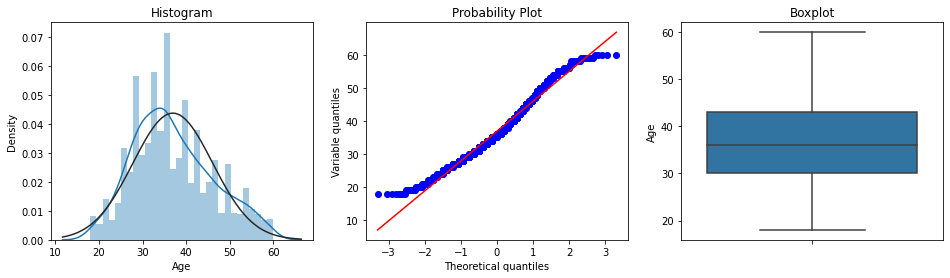

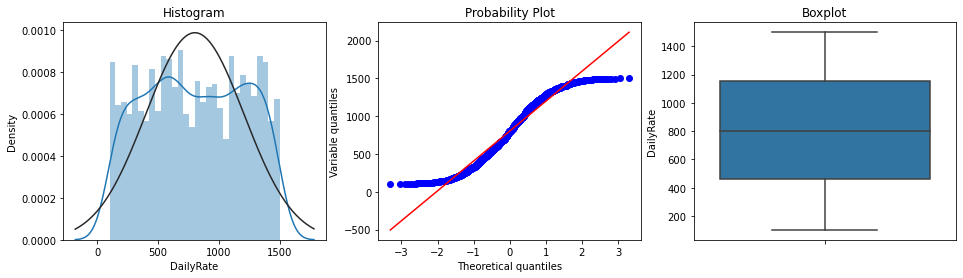

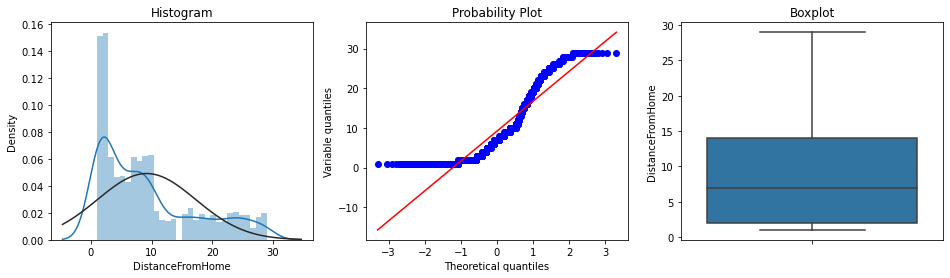

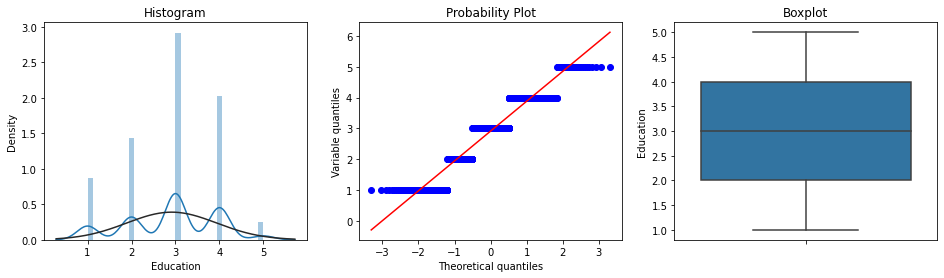

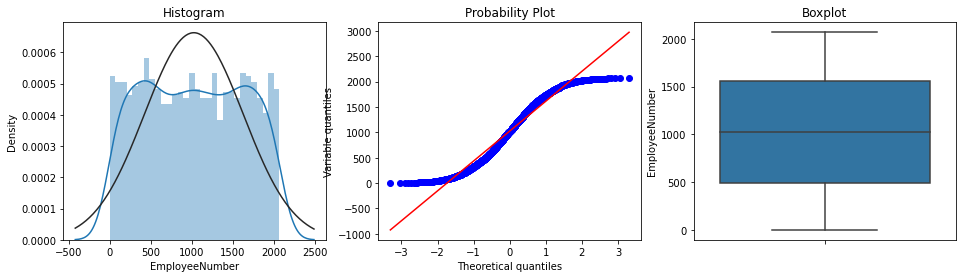

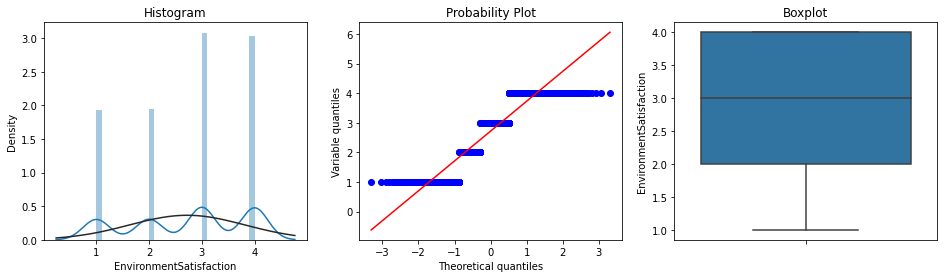

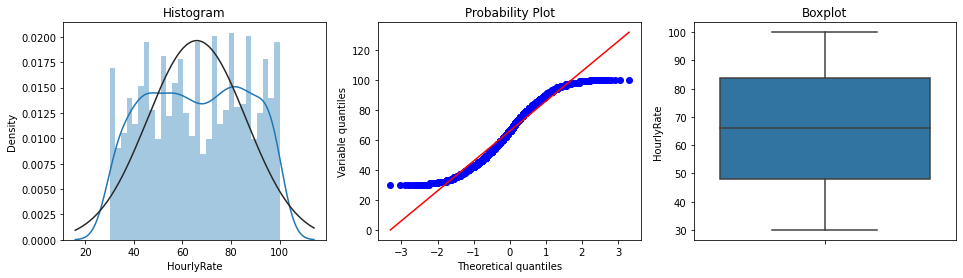

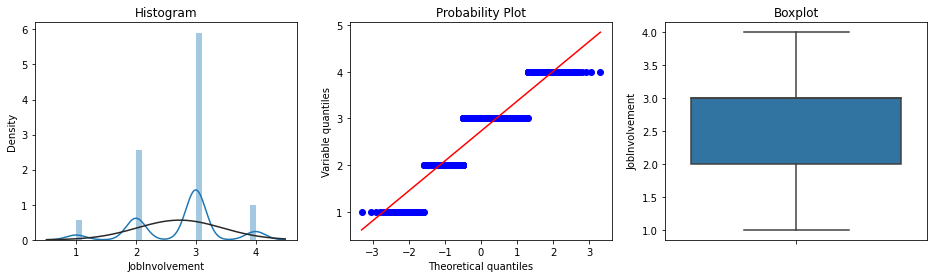

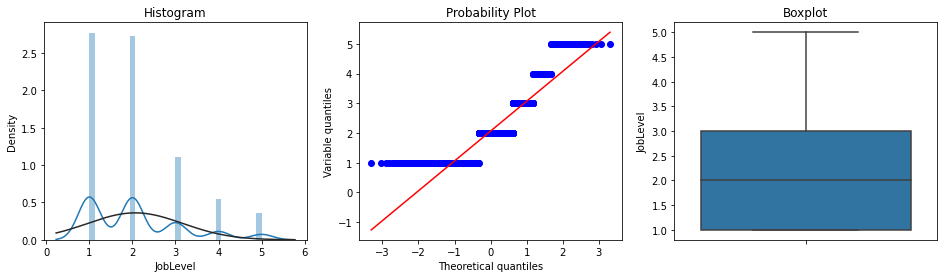

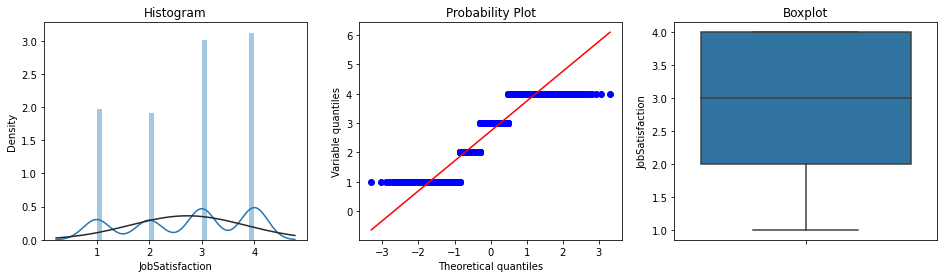

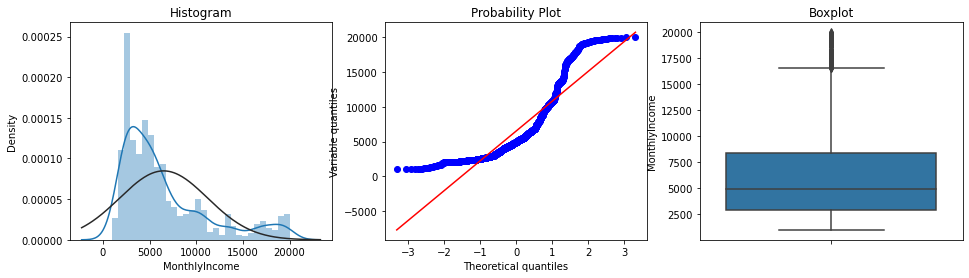

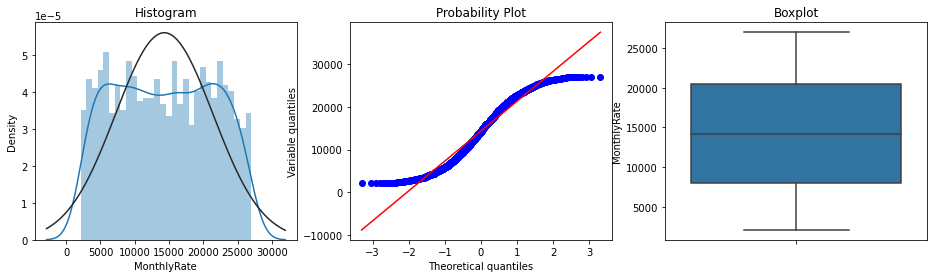

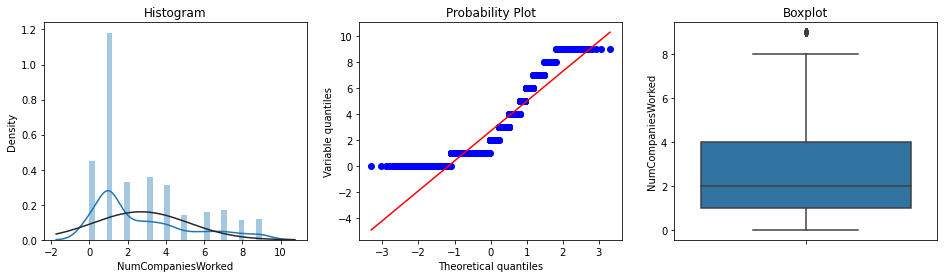

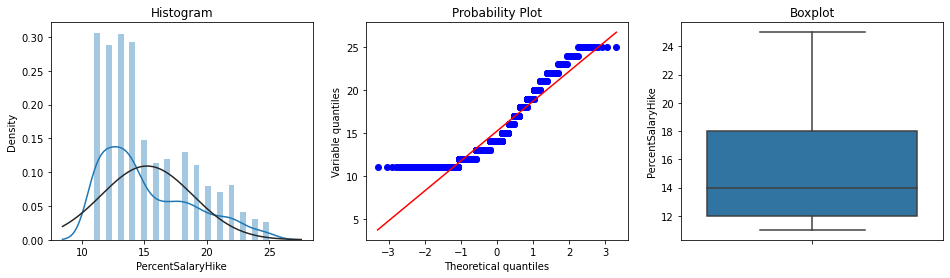

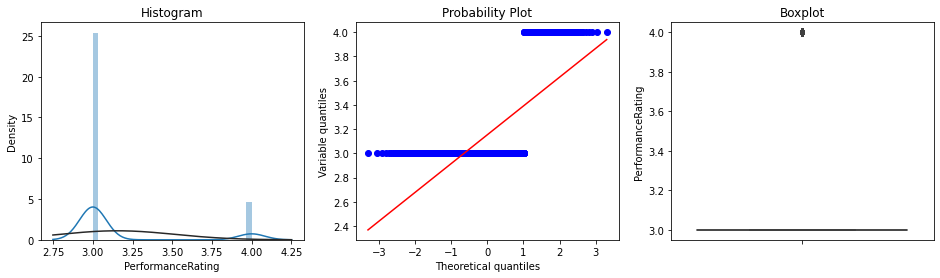

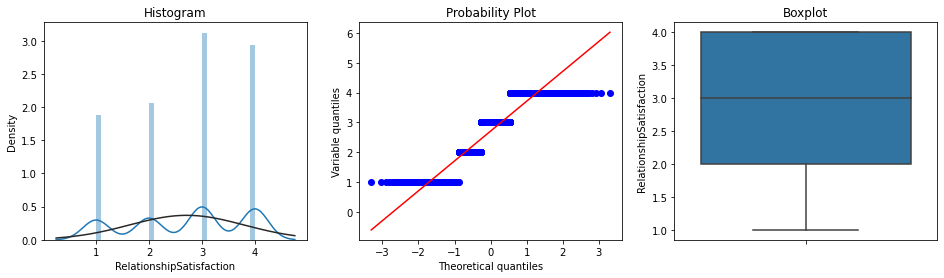

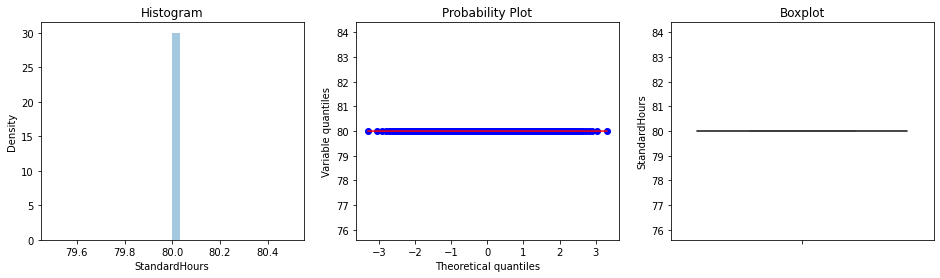

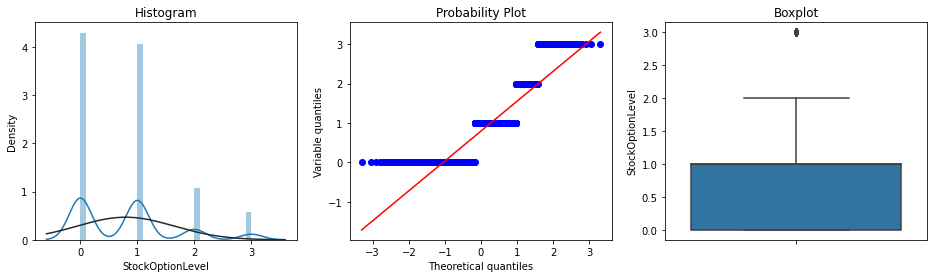

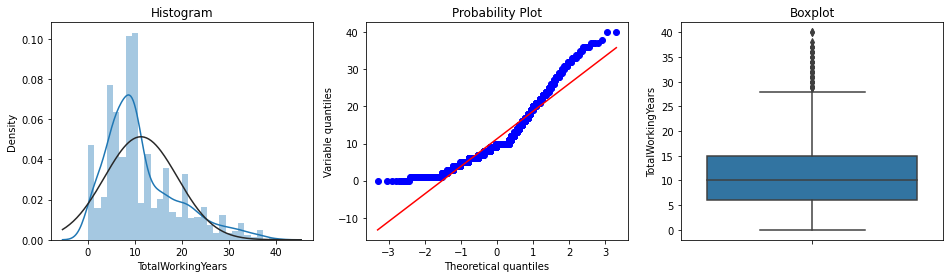

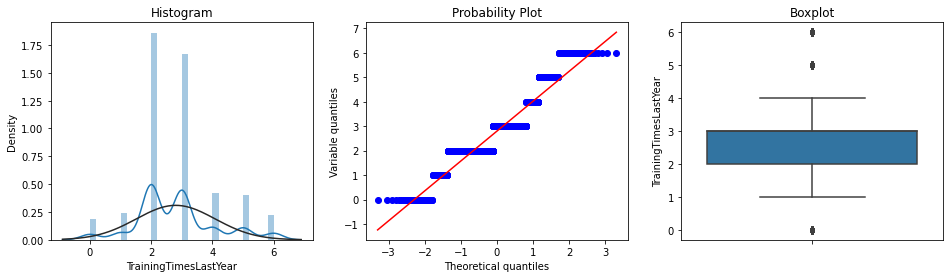

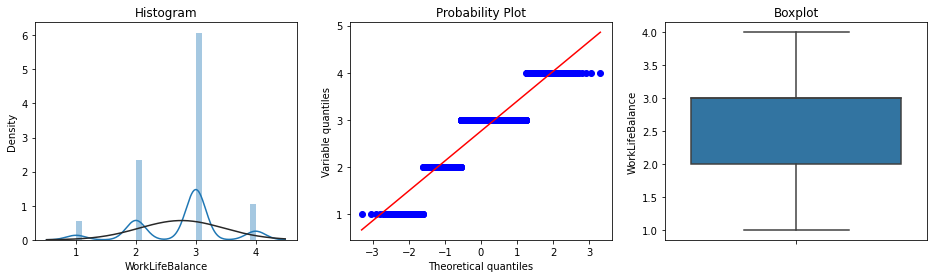

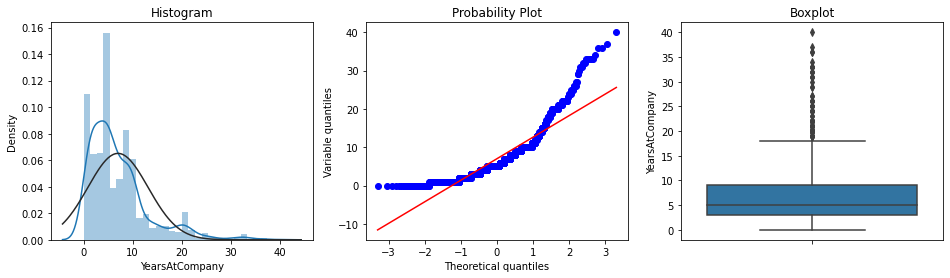

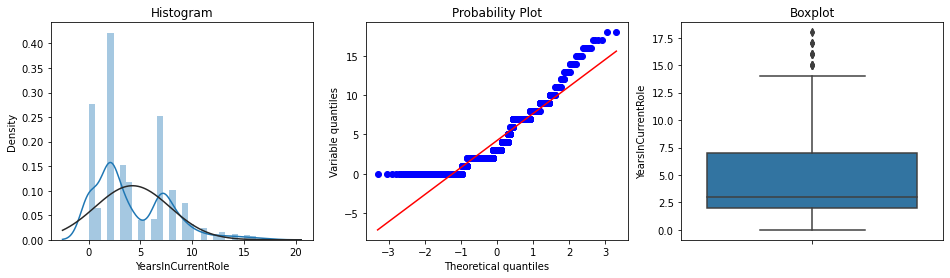

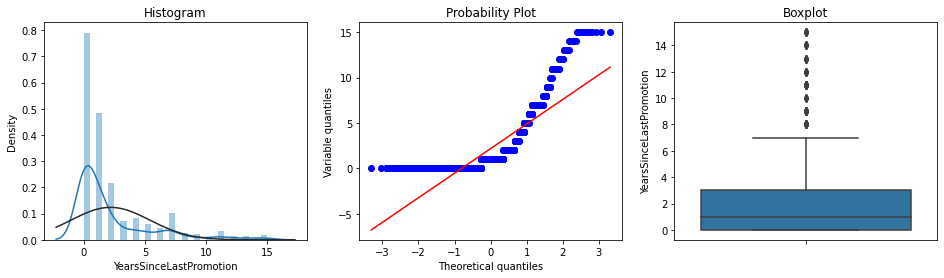

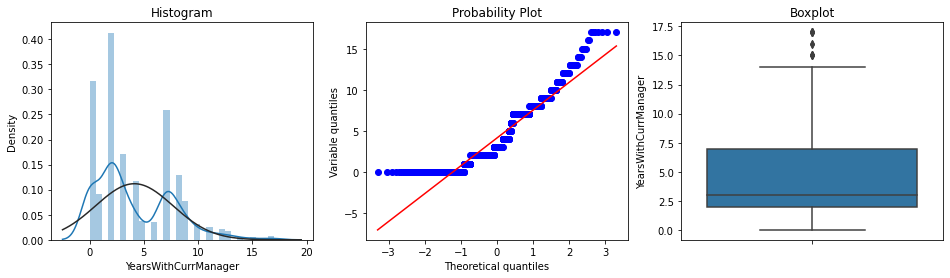

In [10]:
#Let's analyze the distribution of the numeric features
for col in df_HR.select_dtypes(include='number').drop("EmployeeCount",axis=1).astype(int).columns:
    
    diagnostic_plots(df_HR,col)

As we can see, there are some features with low variance (quasi constant features), let's drop them hardcoding to include the categorical features.
Also, we can note that a lot of variables are skewed. We might have to transform them later.

In [11]:
# create an empty list
quasi_constant_feat = []

# iterate over every feature
for feature in df_HR.columns:

    # find the predominant value, that is the value that is shared
    # by most observations
    predominant = (df_HR[feature].value_counts() / np.float(
        len(df_HR))).sort_values(ascending=False).values[0]

    # evaluate the predominant feature: do more than 99% of the observations
    # show 1 value?
    if predominant > 0.998:
        
        # if yes, add the variable to the list
        quasi_constant_feat.append(feature)

print(len(quasi_constant_feat)," features: ",quasi_constant_feat )

3  features:  ['EmployeeCount', 'Over18', 'StandardHours']


In [12]:
#Dropping
df_HR.drop(labels=quasi_constant_feat, axis=1, inplace=True)

<a class="anchor" id="x"></a>
## 2.4. Deeper look at the relationships: Features x Leavers

### 2.4.1. Features with high cardinality:

In [13]:
#Let's see the high cardinality features
high_card = []
for col in df_HR.columns:
    if(df_HR[col].value_counts().count() >15):
        high_card.append(col)
high_card
        

['Age',
 'DailyRate',
 'DistanceFromHome',
 'EmployeeNumber',
 'HourlyRate',
 'MonthlyIncome',
 'MonthlyRate',
 'TotalWorkingYears',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [14]:
#Let's make a function to plot highly cardinal features
def plot_high_cardinality (df_HR,column):
    plt.figure(figsize=(15,6))

    plt.grid(True, alpha=0.5)
    sns.kdeplot(df_HR.loc[df_HR['Attrition'] == 'No', column], label = 'Active Employee')
    sns.kdeplot(df_HR.loc[df_HR['Attrition'] == 'Yes', column], label = 'Ex-Employees')
   # plt.xlim(left=18, right=60)
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.legend()
    plt.title(column +' Distribution by Attrition Status')
    


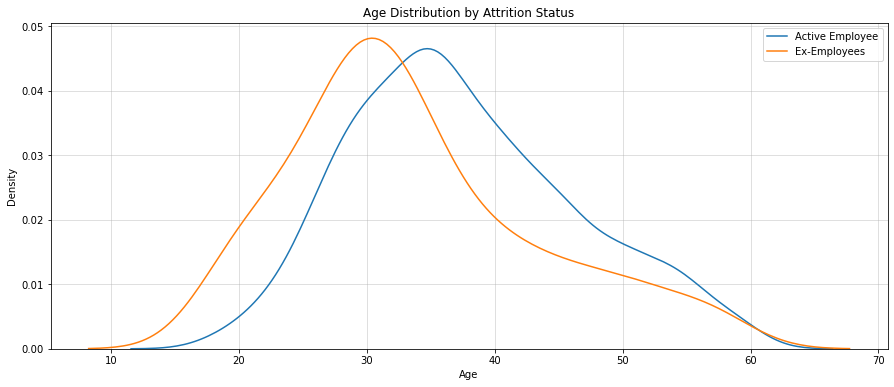

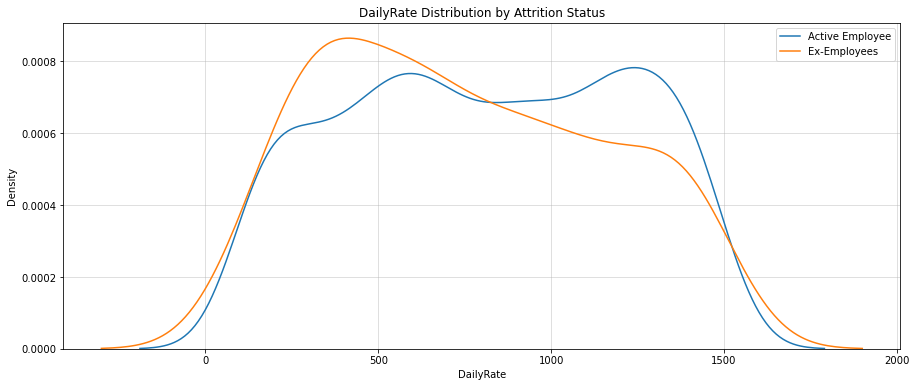

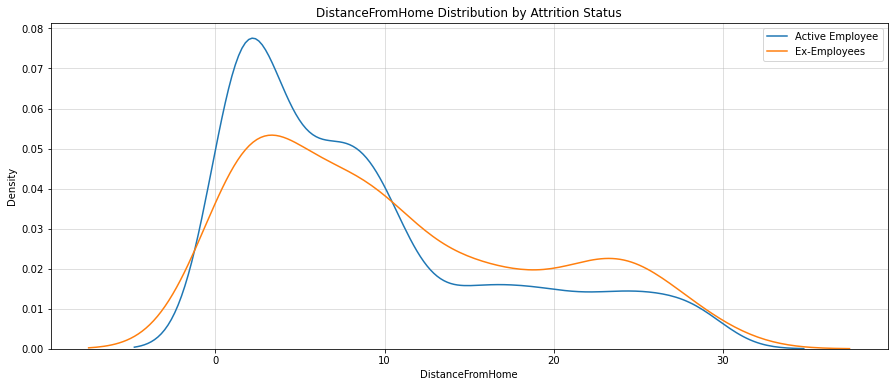

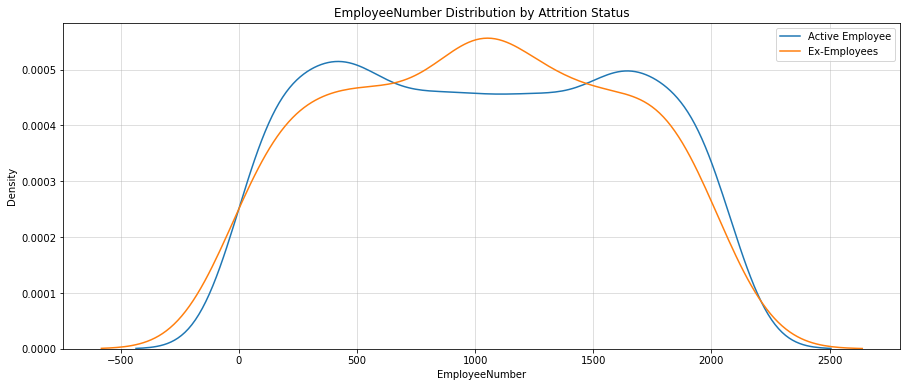

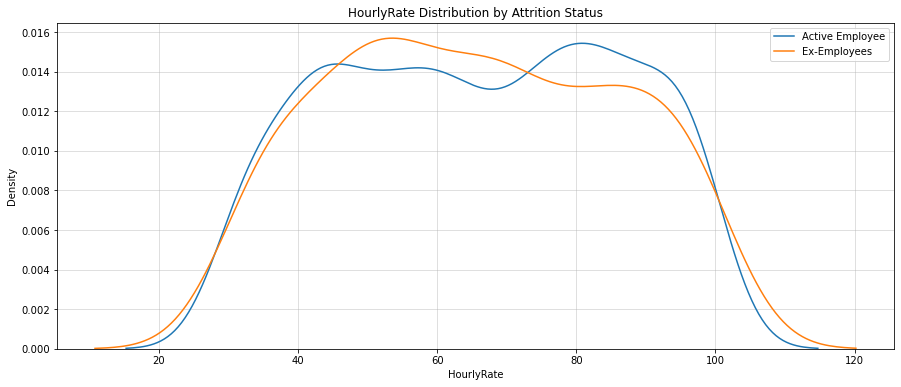

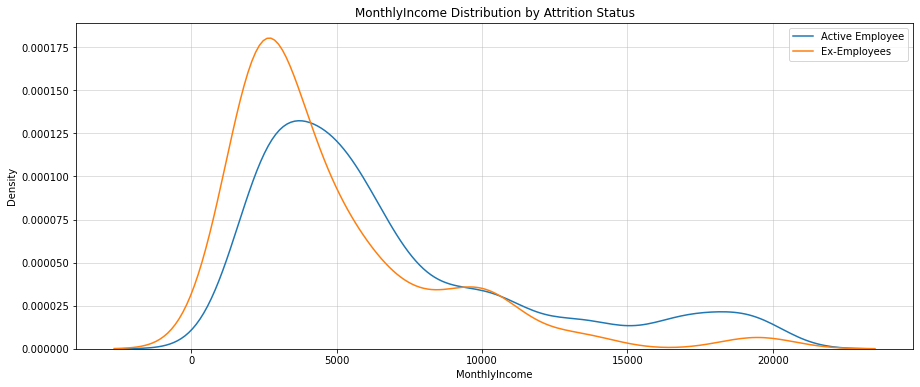

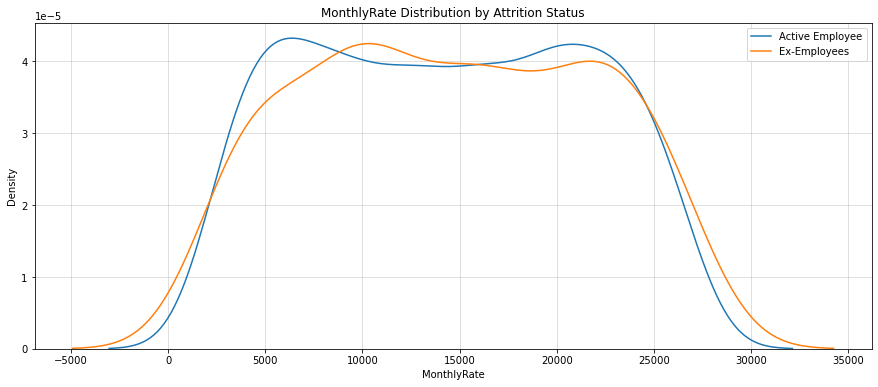

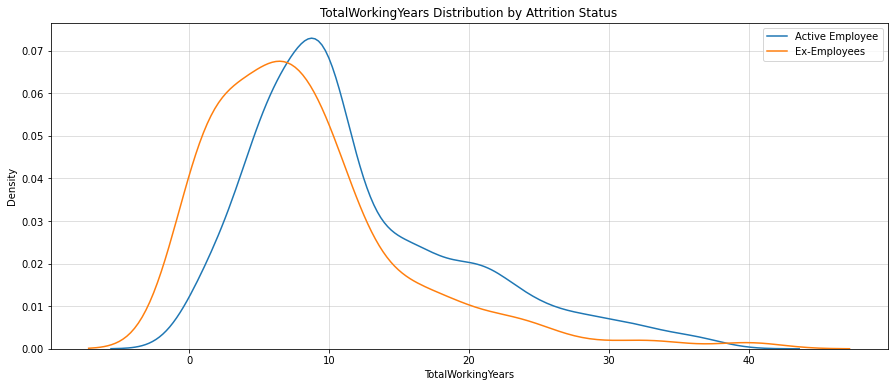

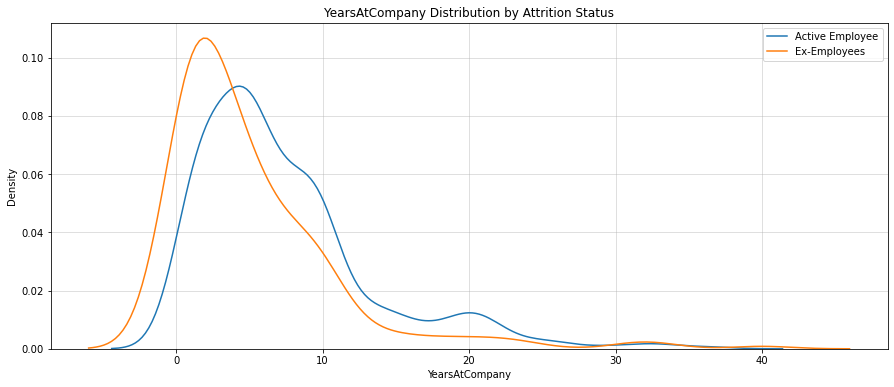

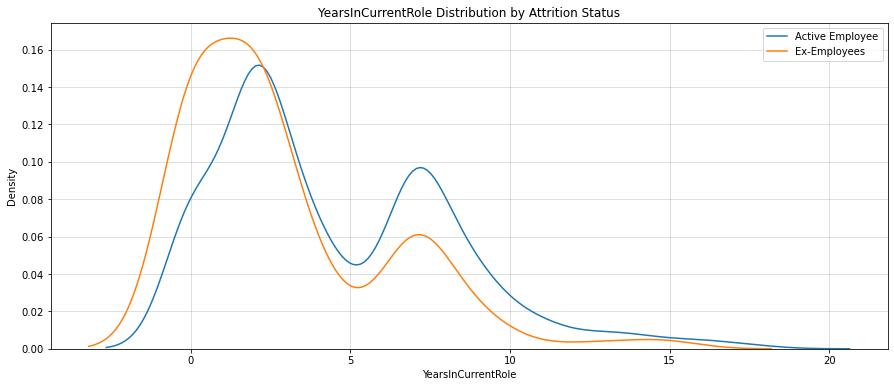

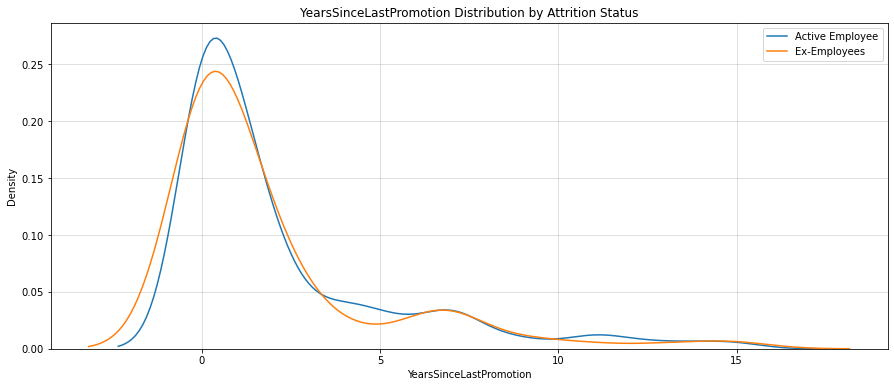

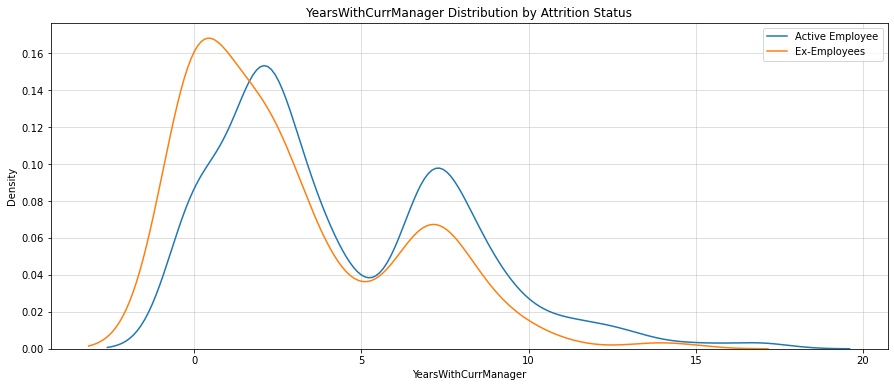

In [15]:
for i in high_card:
    plot_high_cardinality (df_HR,i)

<a class="anchor" id="x2"></a>
### 2.4.2. Features with low cardinality

In [16]:
#Auxiliar function to help the next analysis

def plot_relationships(df_HR,column):
    df = pd.DataFrame(columns=[column, "% of Leavers"])
    i=0
    for field in list(df_HR[column].unique()):
        ratio = df_HR[(df_HR[column]==field)&(df_HR['Attrition']=="Yes")].shape[0] / df_HR[df_HR[column]==field].shape[0]
        df.loc[i] = (field, ratio*100)
        i += 1
   
    df_MF = df.groupby(by=column).sum()
    df_MF.sort_values(by = "% of Leavers",ascending = False).iplot(kind='bar',title="% Leavers by " + column)

In [17]:
for i in df_HR.columns:
    if i not in high_card + ['Attrition']:
        plot_relationships(df_HR, i)
        

<a class="anchor" id="targ"></a>
## 2.5. Target distribution

In [18]:
df_HR['Attrition'].value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

In [19]:
print("Percentage of Current Employees is {:.1f}% and of Ex-employees is: {:.1f}%".format(
    df_HR[df_HR['Attrition'] == 'No'].shape[0] / df_HR.shape[0]*100,
    df_HR[df_HR['Attrition'] == 'Yes'].shape[0] / df_HR.shape[0]*100))

Percentage of Current Employees is 83.9% and of Ex-employees is: 16.1%


So, this is an imbalanced problem, approximately 84/16 %. We will have to handle this distribution before deploying a machine learning model.

<a class="anchor" id="corr"></a>
## 2.6. Correlation first analysis

In [20]:
# Find correlations with the target and sort
df_HR_trans = df_HR.copy()
df_HR_trans['Target'] = df_HR_trans['Attrition'].apply(
    lambda x: 0 if x == 'No' else 1)
df_HR_trans = df_HR_trans.drop(
    ['Attrition', 'EmployeeNumber'], axis=1)
correlations = df_HR_trans.corr()['Target'].sort_values()
print('Most Positive Correlations: \n', correlations.tail(5))
print('\nMost Negative Correlations: \n', correlations.head(5))

Most Positive Correlations: 
 PerformanceRating     0.002889
MonthlyRate           0.015170
NumCompaniesWorked    0.043494
DistanceFromHome      0.077924
Target                1.000000
Name: Target, dtype: float64

Most Negative Correlations: 
 TotalWorkingYears    -0.171063
JobLevel             -0.169105
YearsInCurrentRole   -0.160545
MonthlyIncome        -0.159840
Age                  -0.159205
Name: Target, dtype: float64


<AxesSubplot:>

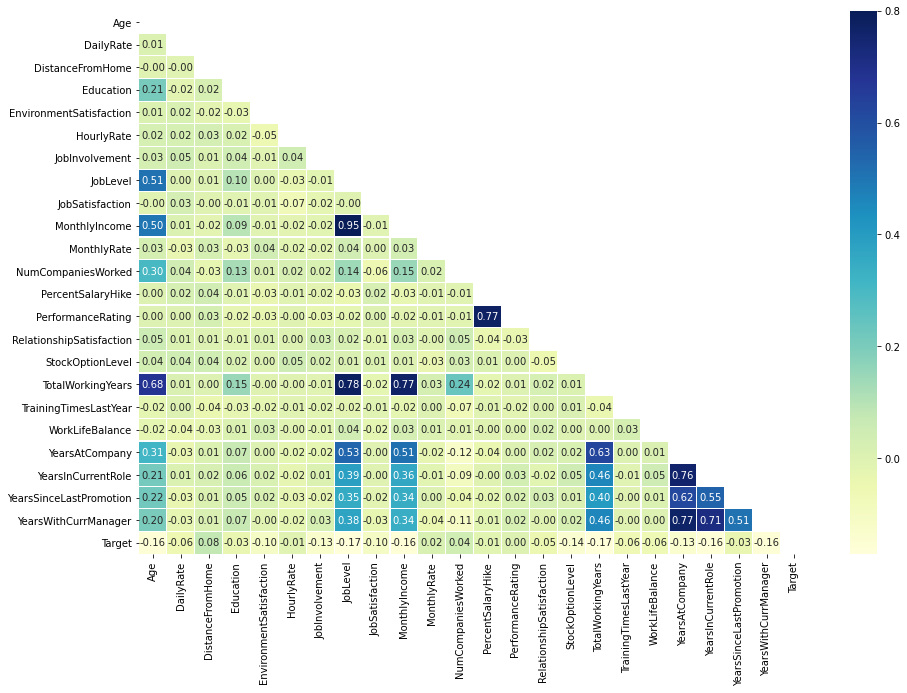

In [21]:
# Calculate correlations
corr = df_HR_trans.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
# Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr,
            vmax=.8,
            mask=mask,
            annot=True, fmt='.2f',
            linewidths=.2, cmap="YlGnBu")

As we can see, "Monthly Rate", "Number of Companies Worked" and "Distance From Home" are positively correlated to Attrition;
while "Total Working Years", "Job Level", and "Years In Current Role" are negatively correlated to Attrition.

<a class="anchor" id="EDA"></a>
# 3. EDA conclusions

- About 10% of leavers left when they reach their 2-year anniversary at the company.
- Loyal employees with higher salaries and more responsbilities show lower proportion of leavers compared to their counterparts.
- People who live further away from their work show higher proportion of leavers compared to their counterparts.
- Single employees show the largest proportion of leavers, compared to Married and Divorced counterparts.
- People who travel frequently show higher proportion of leavers.
- People who have to work overtime show higher proportion of leavers compared to their counterparts.
- Employee who work as Sales Representatives show a significant percentage of Leavers in the submitted dataset.
- Employees that have already worked at several companies previously (already "bounced" between workplaces) show higher proportion of leavers compared to their counterparts.

<a class="anchor" id="pre"></a>
# 4. Pre-processing the data
## 4.1. Encoding

Let's use the simple yet efficient label encoder. Over fitting may be a problem for our imbalanced problem, so it's a good idea to avoid using target oriented encoding methods.

In [22]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Create a label encoder object
le = LabelEncoder()
# Label Encoding will be used for columns with 2 or less unique values
le_count = 0
for col in df_HR.columns[1:]:
    if df_HR[col].dtype == 'object':
        if len(list(df_HR[col].unique())) <= 3:
            le.fit(df_HR[col])
            df_HR[col] = le.transform(df_HR[col])
            le_count += 1
print('{} columns were label encoded.'.format(le_count))

6 columns were label encoded.


In [23]:
# convert rest of categorical variable into dummy, since they don't have high cardinality
df_HR = pd.get_dummies(df_HR, drop_first=True)
print(df_HR.shape)

(1470, 43)


<a class="anchor" id="trans"></a>
## 4.2. Transforming features

Let's see how the skewness is affected with three different variable transformations. The full color bars represent the skewness after the transformation.

### Log:

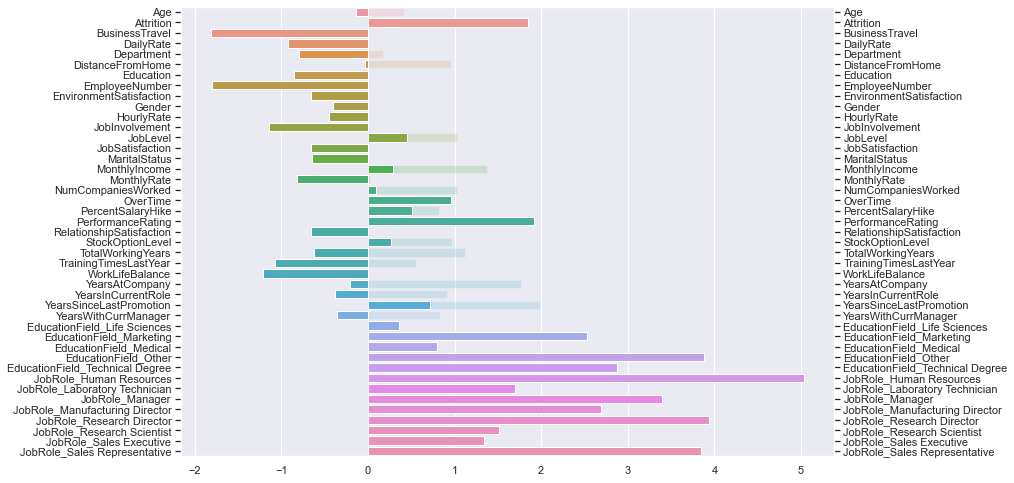

In [24]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
transformation_skew (df_HR, kind='log')

### Yeo-Johnson:

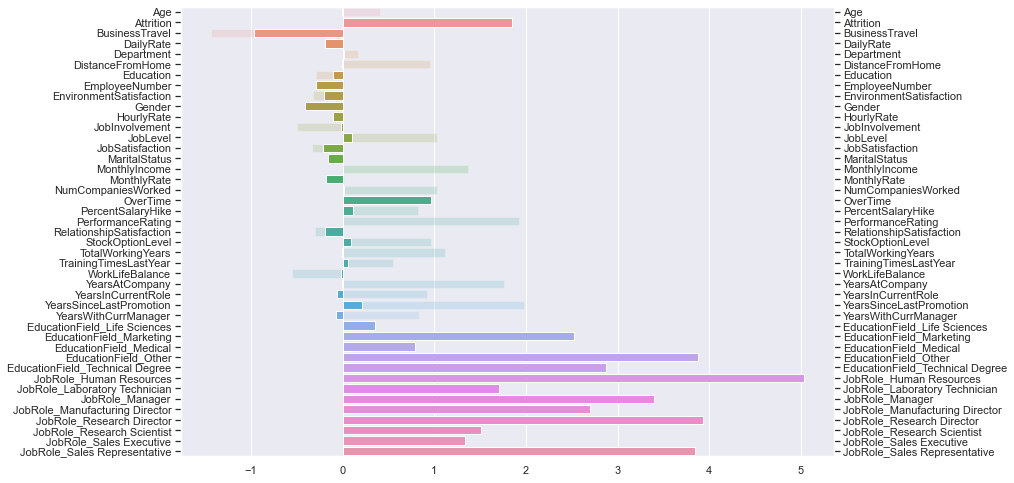

In [25]:
transformation_skew (df_HR, kind='yj')

### Box-Cox:

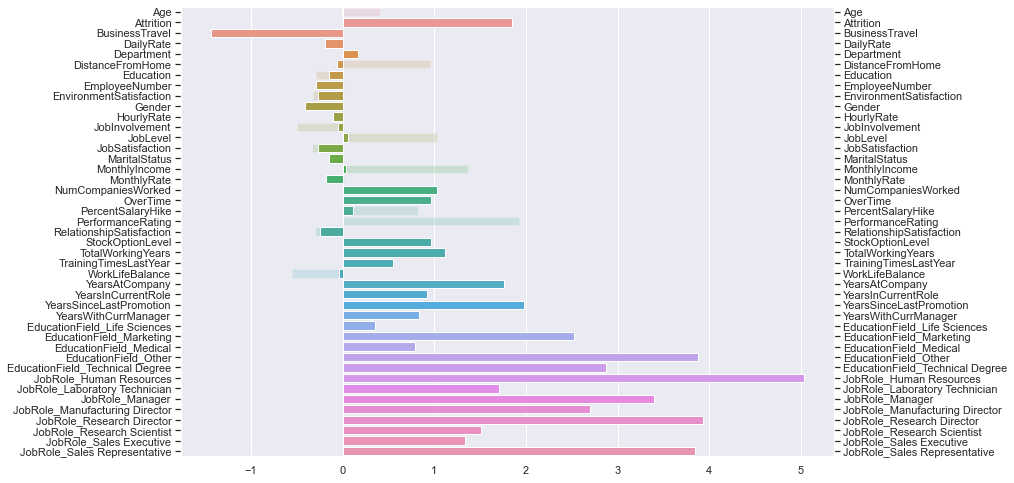

In [26]:
transformation_skew (df_HR, kind='boxcox')

As shown above, Yeo-Johnson transformer fits better our dataset. One important thing to keep in mind is to split the dataset before transforming, to avoid over-fitting, since Yeo-Johnson learns from the data.

<a class="anchor" id="split"></a>
## 4.3. Splitting the data

In [27]:
# Since we have class imbalance (i.e. more employees with turnover=0 than turnover=1)

target = df_HR['Attrition'].copy()
# let's use stratify=y to maintain the same ratio as in the training dataset when splitting the dataset
df_HR.drop(['Attrition',  'EmployeeNumber'
            ], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(df_HR,
                                                    target,
                                                    test_size=0.25,
                                                    random_state=7,
                                                    stratify=target)  
print("X_train dataset: ", X_train.shape)
print("y_train dataset: ", y_train.shape)
print("X_test dataset: ", X_test.shape)
print("y_test dataset: ", y_test.shape)

X_train dataset:  (1102, 41)
y_train dataset:  (1102,)
X_test dataset:  (368, 41)
y_test dataset:  (368,)


In [28]:
import feature_engine.transformation as vt
var = []
#Excluding these two features from the transformer because their values aren't suitable for yjt.
for i in X_train.columns:
    if i not in ['MonthlyIncome','PerformanceRating']:
        var.append(i)
        
yjt = vt.YeoJohnsonTransformer(variables = var)
yjt.fit(X_train)
X_train = yjt.transform(X_train)
X_test = yjt.transform(X_test)
X_train.describe()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative
count,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000
mean,4.657642,17.344247,171.496953,1.139079,1.999591,4.016340,3.833204,0.831352,37.875947,5.369955,0.695855,3.671156,1.029883,6373.103448,1284.166700,1.005429,0.059038,0.681131,3.148820,3.732946,0.424796,3.401093,2.064373,6.031092,2.055121,1.788338,0.511198,1.714160,0.160869,0.008786,0.085564,0.002412,0.005261,0.001007,0.020711,0.002412,0.007163,0.002486,0.029651,0.036686,0.002194
std,0.396913,9.363771,68.499705,0.454695,0.883435,1.639784,1.747583,0.676796,9.910976,1.914612,0.140242,1.671342,0.701073,4632.188714,489.226918,0.603343,0.095696,0.003888,0.356073,1.690381,0.382574,1.340814,0.818449,2.177837,0.928798,1.108524,0.473868,1.103475,0.196666,0.024685,0.124693,0.009636,0.017038,0.005060,0.045541,0.009636,0.021306,0.009855,0.058730,0.068286,0.008990
min,3.622862,0.000000,38.958391,0.000000,0.696515,1.148623,1.162422,0.000000,19.545110,1.362755,0.533254,1.141531,0.000000,1009.000000,331.936247,-0.000000,-0.000000,0.675404,3.000000,1.149113,-0.000000,0.000000,0.000000,1.424613,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
25%,4.379072,4.085154,117.415874,0.928085,1.107089,2.527697,2.579619,0.000000,29.114547,3.388152,0.533254,2.501204,0.971161,2819.500000,872.851521,0.674043,0.000000,0.677519,3.000000,2.529531,0.000000,2.632732,1.595760,3.658174,1.506806,1.275861,0.000000,1.266446,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.620296,23.255385,176.991991,0.928085,2.109949,4.081583,4.192602,1.381825,38.084223,6.015425,0.733390,4.025237,0.971161,4797.000000,1319.270377,1.051137,-0.000000,0.680744,3.000000,4.085491,0.616687,3.493930,2.235424,6.660251,1.996434,1.676228,0.570714,1.660451,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
75%,4.951840,23.255385,233.289364,1.765680,2.759942,5.779910,5.968800,1.381825,46.644125,6.015425,0.841040,5.684452,1.904367,8182.000000,1702.470219,1.508920,0.214014,0.684811,3.000000,5.786542,0.616687,4.300747,2.235424,6.660251,2.647783,2.776492,0.812377,2.736298,0.401080,-0.000000,0.267115,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
max,5.511358,23.255385,279.786428,1.765680,3.483320,7.602989,5.968800,1.381825,53.992018,9.205618,0.956555,5.684452,1.904367,19973.000000,2076.839348,2.100558,0.214014,0.688457,4.000000,5.786542,1.102520,6.770014,3.875135,10.403868,4.666211,4.349399,1.378557,4.259407,0.401080,0.078081,0.267115,0.040884,0.060390,0.026418,0.120761,0.040884,0.070480,0.041513,0.145872,0.163676,0.038997


<a class="anchor" id="scale"></a>
## 4.4. Scaling
As we can see, the skewnesses are decreased, but the values aren't scaled yet. We're going to use the min-max scaling since it doesn't affect the skewness of the features.

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
columns = list(X_train.columns)

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train,columns = columns)
X_test = pd.DataFrame(X_test,columns = columns)

X_train.describe()


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative
count,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000
mean,0.547939,0.745816,0.550345,0.645122,0.467588,0.444306,0.555675,0.601633,0.532148,0.510936,0.384124,0.556828,0.540801,0.282857,0.545721,0.478648,0.275862,0.438760,0.148820,0.557169,0.385296,0.502376,0.532723,0.513014,0.440426,0.411169,0.370821,0.402441,0.401089,0.112523,0.320327,0.058984,0.087114,0.038113,0.171506,0.058984,0.101633,0.059891,0.203267,0.224138,0.056261
std,0.210174,0.402650,0.284434,0.257518,0.317006,0.254058,0.363597,0.489784,0.287717,0.244122,0.331306,0.367900,0.368140,0.244262,0.280375,0.287230,0.447151,0.297871,0.356073,0.364508,0.347000,0.198052,0.211205,0.242541,0.199048,0.254868,0.343742,0.259068,0.490341,0.316152,0.466814,0.235701,0.282131,0.191555,0.377122,0.235701,0.302303,0.237393,0.402612,0.417203,0.230530
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400430,0.175665,0.325782,0.525625,0.147328,0.213665,0.294857,0.000000,0.277802,0.258247,0.000000,0.299295,0.509965,0.095470,0.309997,0.320888,0.000000,0.162074,0.000000,0.297669,0.000000,0.388881,0.411795,0.248747,0.322919,0.293342,0.000000,0.297329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.528163,1.000000,0.573163,0.525625,0.507188,0.454415,0.630450,1.000000,0.538194,0.593236,0.472798,0.634769,0.509965,0.199747,0.565839,0.500408,0.000000,0.409147,0.000000,0.633191,0.559344,0.516089,0.576863,0.583082,0.427849,0.385393,0.413994,0.389831,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.703723,1.000000,0.806928,1.000000,0.740428,0.717543,1.000000,1.000000,0.786689,0.593236,0.727109,1.000000,1.000000,0.378243,0.785450,0.718342,1.000000,0.720706,0.000000,1.000000,0.559344,0.635264,0.576863,0.583082,0.567438,0.638362,0.589295,0.642413,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<a class="anchor" id="sel"></a>
## 4.5. Feature selection

Let's recall our correlation matrix

<a class="anchor" id="sel"></a>
### 4.5.1. Correlation based elimination

<AxesSubplot:>

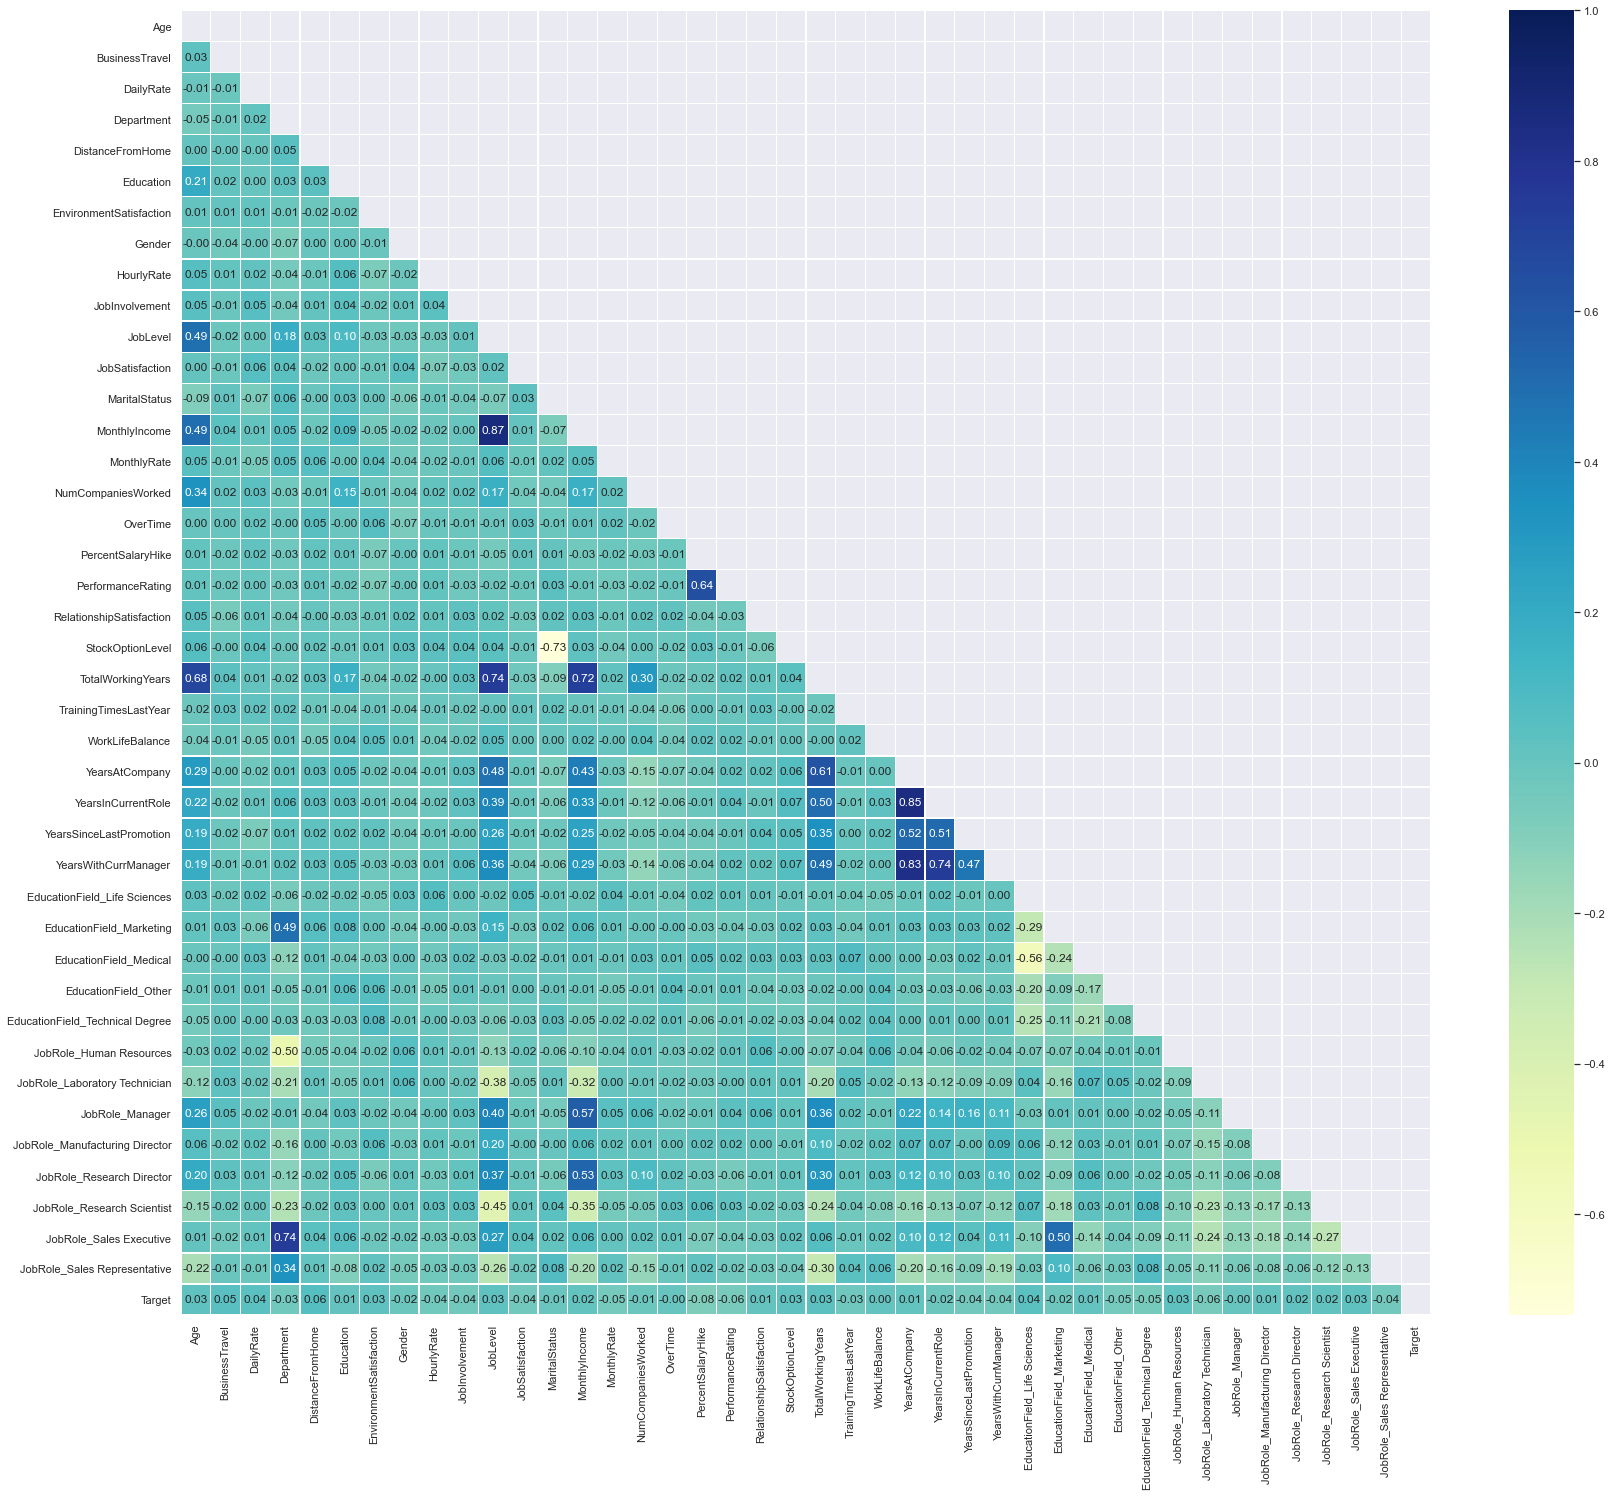

In [30]:
# Find correlations with the target and sort
df_HR_trans = X_train.copy()
df_HR_trans['Target'] = y_train
correlations = df_HR_trans.corr()['Target'].sort_values()
# Calculate correlations
corr = df_HR_trans.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
# Heatmap
plt.figure(figsize=(28, 24))
sns.heatmap(corr,
            vmax=1,
            mask=mask,
            annot=True, fmt='.2f',
            linewidths=.2, cmap="YlGnBu")

In [31]:
X_train.drop(['JobLevel'],axis=1,inplace=True)
X_test.drop(['JobLevel'],axis=1,inplace=True)

Checking the new heatmap. As we can see, the correlations with the target are quite low in our data

<AxesSubplot:>

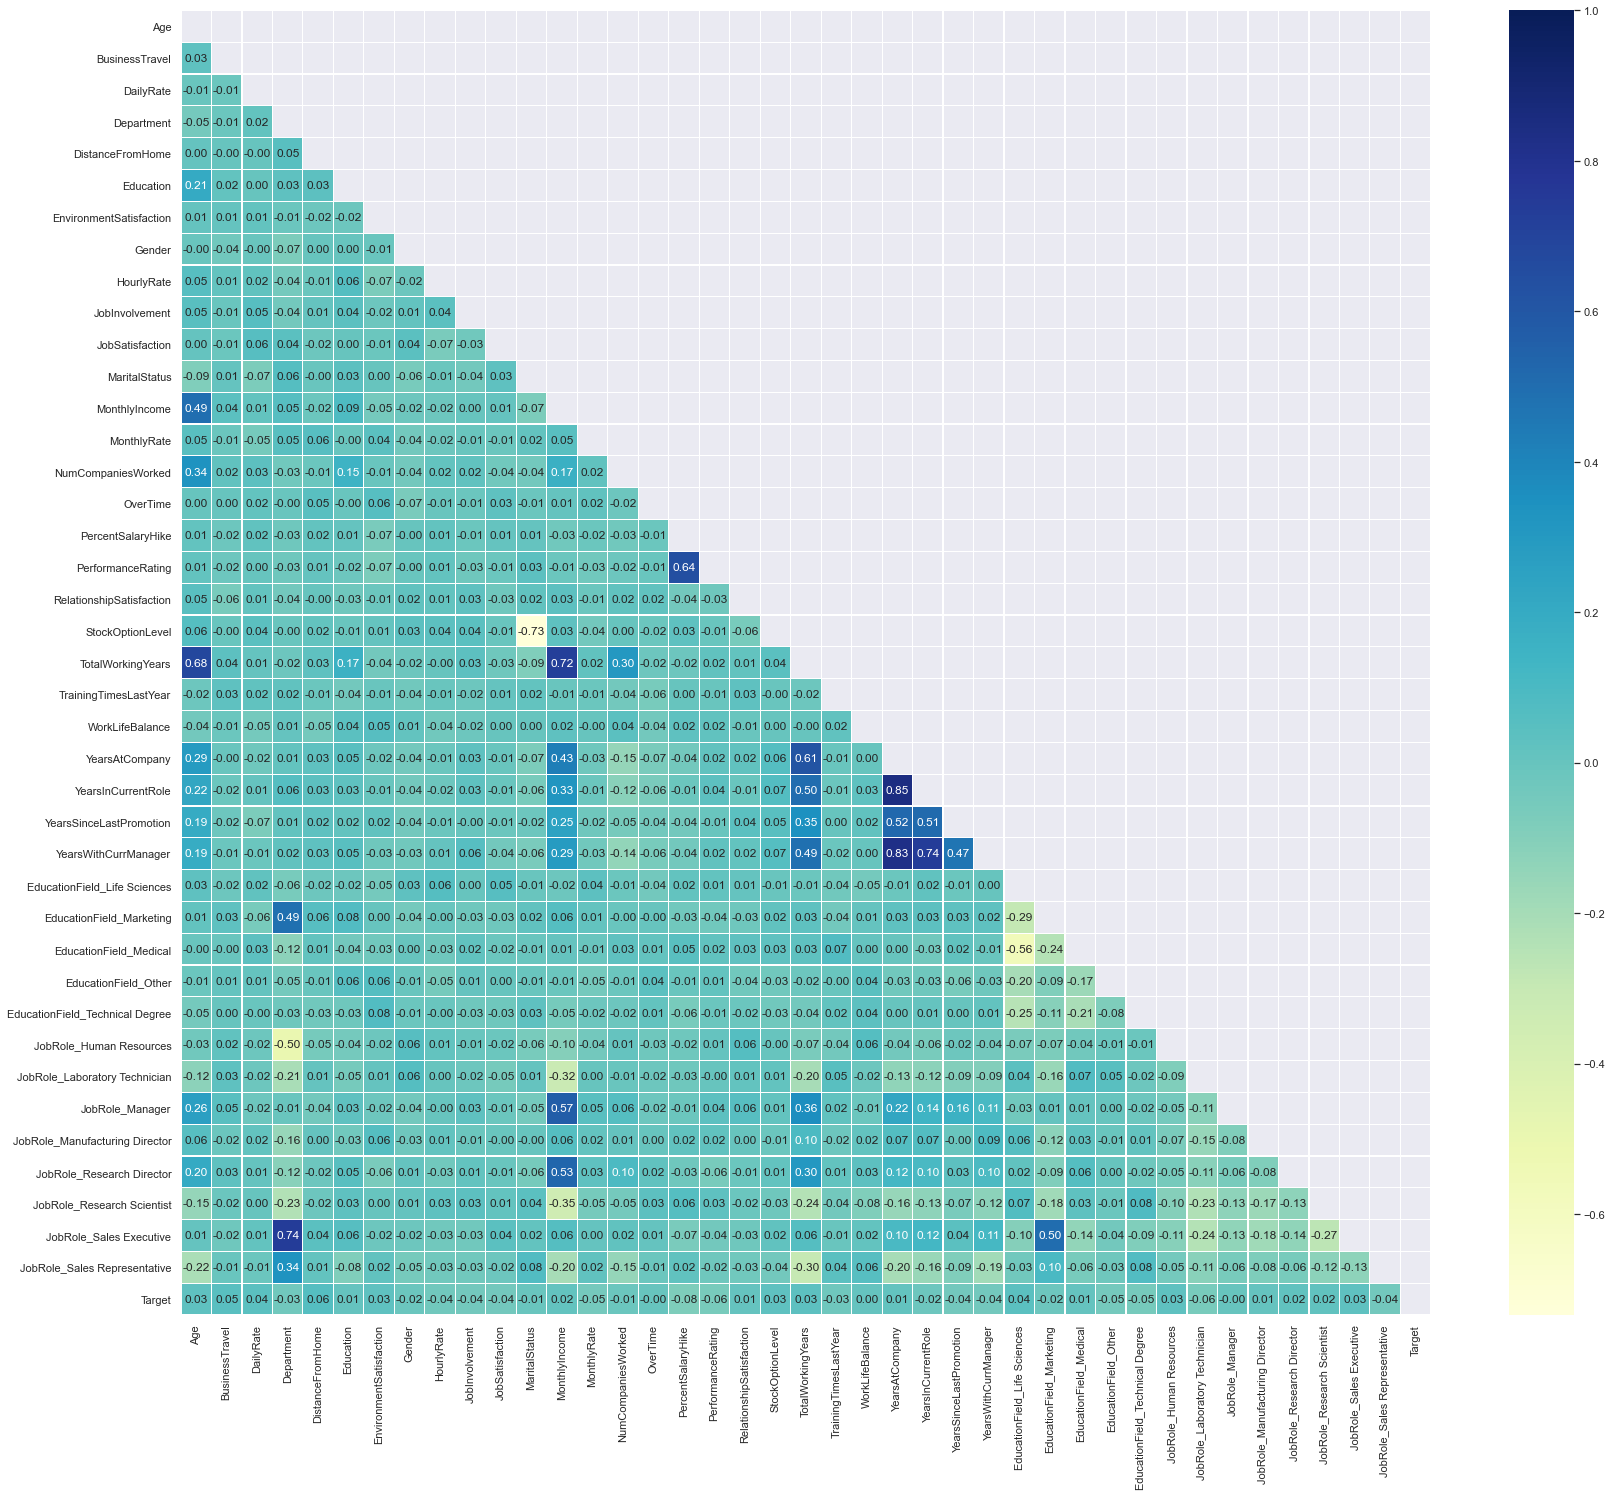

In [32]:
# Find correlations with the target and sort
df_HR_trans = X_train.copy()
df_HR_trans['Target'] = y_train
correlations = df_HR_trans.corr()['Target'].sort_values()
# Calculate correlations
corr = df_HR_trans.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
# Heatmap
plt.figure(figsize=(28, 24))
sns.heatmap(corr,
            vmax=1,
            mask=mask,
            annot=True, fmt='.2f',
            linewidths=.2, cmap="YlGnBu")

<a class="anchor" id="pv"></a>
### 4.5.2. P-value based elimination
Now, to select the final features for our model, we're going to select them by the Fisher Score. In other words, we're using the features with smallest p-values

In [33]:
from sklearn.feature_selection import chi2
# calculate the chi2 p_value between each of the variables
# and the target

# chi2 returns 2 arrays, one contains the F-Scores which are then
# evaluated against the chi2 distribution to obtain the pvalue.
# The pvalues are in the second array

f_score = chi2(X_train, y_train)

# the 2 arrays of values
f_score

(array([2.34826972e+00, 2.22091401e-01, 3.08431868e-01, 5.46880920e-01,
        1.64961505e+00, 1.15631049e-02, 2.04619733e+00, 9.17053131e-05,
        9.25008428e-02, 1.76760813e+00, 2.02140378e+00, 6.46615646e+00,
        6.05734792e+00, 7.13024036e-02, 2.36337972e-01, 5.80703038e+01,
        5.77170878e-02, 5.54673106e-01, 5.08521434e-01, 9.64866232e+00,
        3.31628080e+00, 3.58042805e-01, 4.28821198e-01, 2.99455910e+00,
        5.84110275e+00, 1.70128077e+00, 4.99485459e+00, 3.22504165e-01,
        4.79211855e+00, 3.02114566e+00, 2.55278804e-01, 4.31903328e+00,
        2.59937138e-01, 9.35179523e+00, 8.20546083e+00, 4.31549009e+00,
        8.39121700e+00, 1.08572540e-03, 2.87914333e-01, 2.67436634e+01]),
 array([1.25422152e-01, 6.37450976e-01, 5.78644052e-01, 4.59594957e-01,
        1.99011333e-01, 9.14367036e-01, 1.52586891e-01, 9.92359344e-01,
        7.61021605e-01, 1.83678369e-01, 1.55095702e-01, 1.09948068e-02,
        1.38485503e-02, 7.89449836e-01, 6.26863627e-01, 2.5291

In [34]:
# 1) let's capture the p_values (in the second array, remember python indexes at 0) in a pandas Series
# 2) add the variable names in the index
# 3) order the variables based on their fscore

pvalues = pd.Series(f_score[1])
pvalues.index = X_train.columns
pvalues.sort_values(ascending=True)

OverTime                           2.529156e-14
JobRole_Sales Representative       2.323123e-07
StockOptionLevel                   1.894895e-03
JobRole_Laboratory Technician      2.227672e-03
JobRole_Research Director          3.770384e-03
JobRole_Manager                    4.176450e-03
MaritalStatus                      1.099481e-02
MonthlyIncome                      1.384855e-02
YearsInCurrentRole                 1.565601e-02
YearsWithCurrManager               2.542279e-02
EducationField_Marketing           2.859024e-02
EducationField_Technical Degree    3.768833e-02
JobRole_Manufacturing Director     3.776689e-02
TotalWorkingYears                  6.859685e-02
EducationField_Medical             8.218539e-02
YearsAtCompany                     8.354465e-02
Age                                1.254222e-01
EnvironmentSatisfaction            1.525869e-01
JobSatisfaction                    1.550957e-01
JobInvolvement                     1.836784e-01
YearsSinceLastPromotion            1.921

Now, let's drop the bottom 5 features. We can do it manually or we can use SK-Learn's "Select K best". Let's use Sk's method for simplicity

In [35]:
from sklearn.feature_selection import SelectKBest
sel_ = SelectKBest(chi2, k=len(X_train.columns) - 5).fit(X_train, y_train)

# display features to be dropped
set(X_train.columns) - set(X_train.columns[sel_.get_support()])

{'Education',
 'Gender',
 'JobRole_Research Scientist',
 'MonthlyRate',
 'PercentSalaryHike'}

<a class="anchor" id="m"></a>
# 5. Building models
## 5.1. First evaluations
Let's do a first analysis without concerning ourselves with hyperparameters just to get a rough estimate of how different models work on our data.

In [36]:
# selection of algorithms to consider and set performance measure
models = []
models.append(('Logistic Regression', LogisticRegression(solver='liblinear', random_state=7,
                                                         class_weight='balanced')))
models.append(('Random Forest', RandomForestClassifier(
    n_estimators=100, random_state=7)))
models.append(('SVM', SVC(gamma='auto', random_state=7)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Decision Tree Classifier',
               DecisionTreeClassifier(random_state=7)))
models.append(('Gaussian NB', GaussianNB()))

<a class="anchor" id="m2"></a>
## 5.2. Comparing the first results

In [37]:
acc_results = []
auc_results = []
names = []
# set table to table to populate with performance results
header = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 
       'Accuracy Mean', 'Accuracy STD']
df_results = pd.DataFrame(columns=header)
i = 0
# evaluate each model using cross-validation
for name, model in models:
    kfold = model_selection.KFold(
        n_splits=10)  # 10-fold cross-validation

    cv_acc_results = model_selection.cross_val_score(  # accuracy scoring
        model, X_train, y_train, cv=kfold, scoring='accuracy')

    cv_auc_results = model_selection.cross_val_score(  # roc_auc scoring
        model, X_train, y_train, cv=kfold, scoring='roc_auc')

    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(name)
    df_results.loc[i] = [name,
                         round(cv_auc_results.mean()*100, 2),
                         round(cv_auc_results.std()*100, 2),
                         round(cv_acc_results.mean()*100, 2),
                         round(cv_acc_results.std()*100, 2)
                         ]
    i += 1
df_results.sort_values(by=['ROC AUC Mean'], ascending=False)

,Algorithm,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
2,SVM,81.67,6.06,83.84,4.50
0,Logistic Regression,80.53,7.59,75.21,5.30
1,Random Forest,79.22,6.80,85.75,3.93
5,Gaussian NB,75.23,4.22,71.41,2.57
3,KNN,68.52,6.25,83.66,4.21
4,Decision Tree Classifier,60.70,4.70,77.04,4.04


Classification accuracy is the number of correct predictions made as a ratio of all predictions made.
It is the most common evaluation metric for classification problems. However, it is often misused as it is only really suitable when there are an equal number of observations in each class and all predictions and prediction errors are equally important. It is not the case in this project, so a different scoring metric may be more suitable.

<Figure size 1080x864 with 0 Axes>

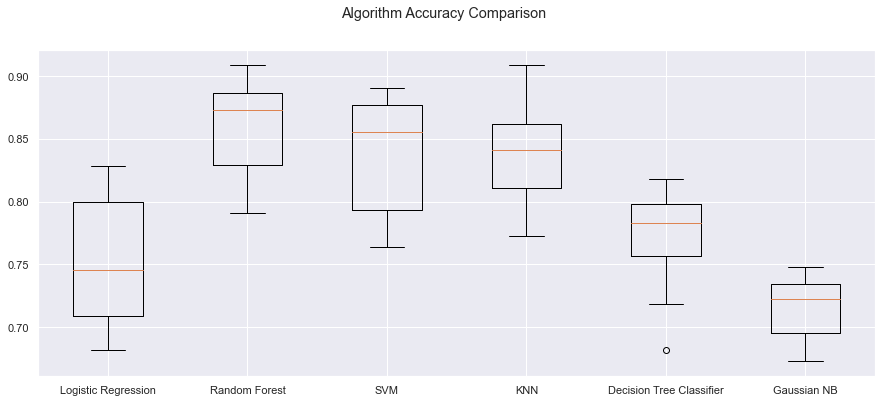

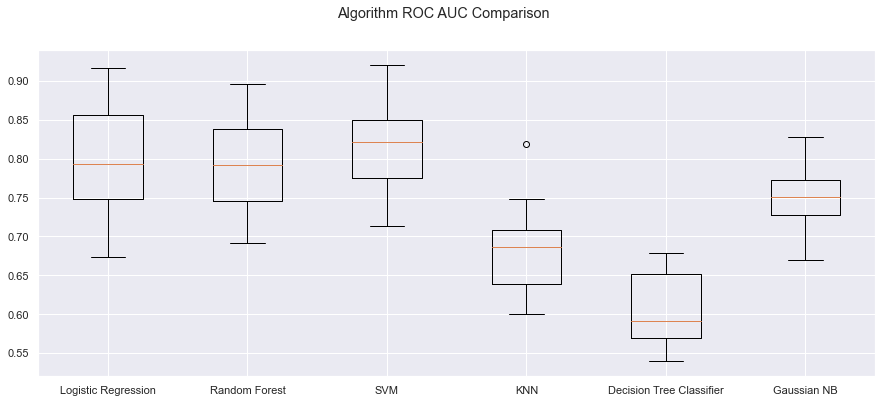

In [38]:
fig = plt.figure(figsize=(15, 12))

#Comparing accurary scores
fig = plt.figure(figsize=(15, 6))
fig.suptitle('Algorithm Accuracy Comparison')
ax = fig.add_subplot(111)
plt.boxplot(acc_results)
ax.set_xticklabels(names)
plt.show()
#Comparing AUC scores
fig = plt.figure(figsize=(15, 6))
fig.suptitle('Algorithm ROC AUC Comparison')
ax = fig.add_subplot(111)
plt.boxplot(auc_results)
ax.set_xticklabels(names)
plt.show()

Now, we can filter some models and tune the best of them.

<a class="anchor" id="m3"></a>
## 5.3. Applying and evaluating the best models
### 5.3.1 Logistic Regression

In [39]:
param_grid = {'C': np.arange(1e-03, 2, 0.01)} # hyper-parameter list to fine-tune
log_gs = GridSearchCV(LogisticRegression(solver='liblinear', # setting GridSearchCV
                                         class_weight="balanced", 
                                         random_state=8),                     
                      return_train_score=True,
                      param_grid=param_grid,
                      scoring='roc_auc',
                      cv=10)

log_grid = log_gs.fit(X_train, y_train)
log_opt = log_grid.best_estimator_
results = log_gs.cv_results_

print('='*20)
print("best params: " + str(log_gs.best_estimator_))
print("best params: " + str(log_gs.best_params_))
print('best score:', log_gs.best_score_)
print('='*20)

best params: LogisticRegression(C=0.581, class_weight='balanced', random_state=8,
                   solver='liblinear')
best params: {'C': 0.581}
best score: 0.8062435259283705


Text(0.5, 527.9871999999999, 'Predicted label')

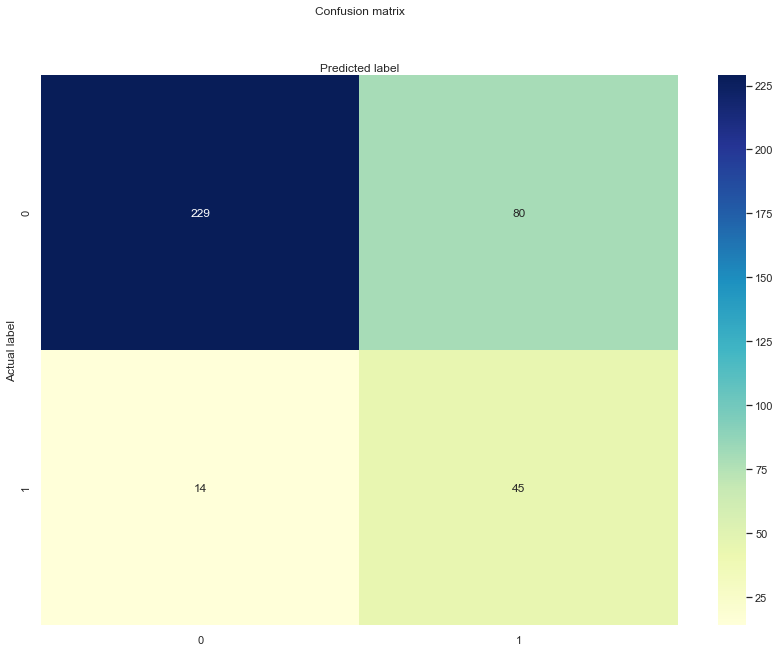

In [40]:
## Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, log_opt.predict(X_test))
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [41]:
print('Accuracy of Logistic Regression Classifier on test set: {:.2f}'.format(log_opt.score(X_test, y_test)*100))

Accuracy of Logistic Regression Classifier on test set: 74.46


In [42]:
# Classification report for the optimised LR Regression
print(classification_report(y_test, log_opt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.74      0.83       309
           1       0.36      0.76      0.49        59

    accuracy                           0.74       368
   macro avg       0.65      0.75      0.66       368
weighted avg       0.85      0.74      0.78       368



<a class="anchor" id="m4"></a>
### 5.3.2. Random Forest 

In [43]:
rf_classifier = RandomForestClassifier(class_weight = "balanced",
                                       random_state=7)
param_grid = {'n_estimators': [100,150,175],
              'min_samples_split':[10,5,6,4],
              'min_samples_leaf': [3,4,5],
              'max_depth': [10,5,4]}

grid_obj = GridSearchCV(rf_classifier,
                        return_train_score=True,
                        param_grid=param_grid,
                        scoring='roc_auc',
                        cv=10)

grid_fit = grid_obj.fit(X_train, y_train)
rf_opt = grid_fit.best_estimator_

print('='*20)
print("best params: " + str(grid_obj.best_estimator_))
print("best params: " + str(grid_obj.best_params_))
print('best score:', grid_obj.best_score_)
print('='*20)

best params: RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=3, min_samples_split=10,
                       n_estimators=150, random_state=7)
best params: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 150}
best score: 0.7831095863622057


Random Forest allows us to know which features are of the most importance in predicting the target feature ("attrition" in this project). Below, we plot features by their importance.

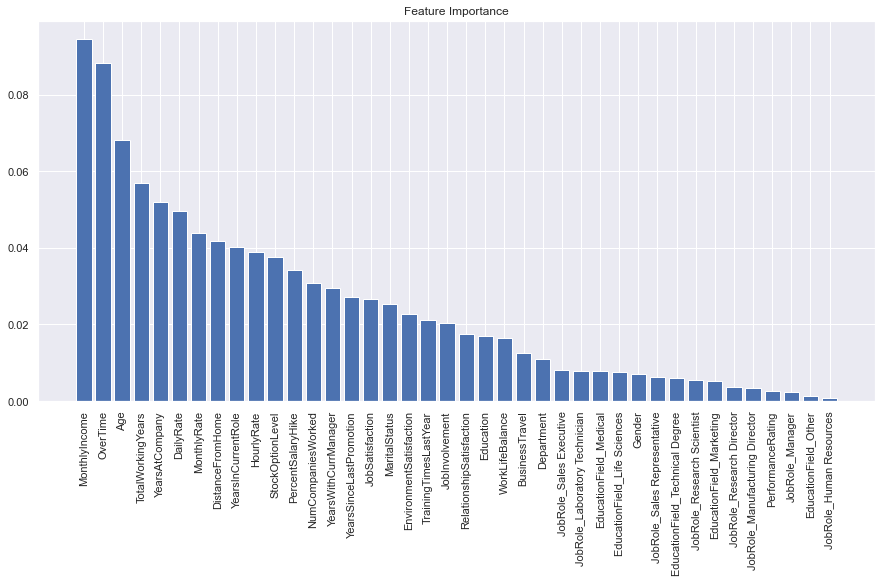

In [44]:
importances = rf_opt.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [X_train.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances
plt.figure(figsize=(15, 7)) # Create plot
plt.title("Feature Importance") # Create plot title
plt.bar(range(X_train.shape[1]), importances[indices]) # Add bars
plt.xticks(range(X_train.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() # Show plot

Using the data from the feature importance, we can create a table to guide us in the final conclusions

In [45]:
importances = rf_opt.feature_importances_
df_param_coeff = pd.DataFrame(columns=['Feature', 'Coefficient'])
for i in range(38):
    feat = X_train.columns[i]
    coeff = importances[i]
    df_param_coeff.loc[i] = (feat, coeff)
df_param_coeff.sort_values(by='Coefficient', ascending=False, inplace=True)
df_param_coeff = df_param_coeff.reset_index(drop=True)
df_param_coeff.head(10)

,Feature,Coefficient
0,MonthlyIncome,0.094576
1,OverTime,0.088214
2,Age,0.068061
3,TotalWorkingYears,0.056976
4,YearsAtCompany,0.052074
5,DailyRate,0.049627
6,MonthlyRate,0.043917
7,DistanceFromHome,0.041730
8,YearsInCurrentRole,0.040330
9,HourlyRate,0.039021


Text(0.5, 527.9871999999999, 'Predicted label')

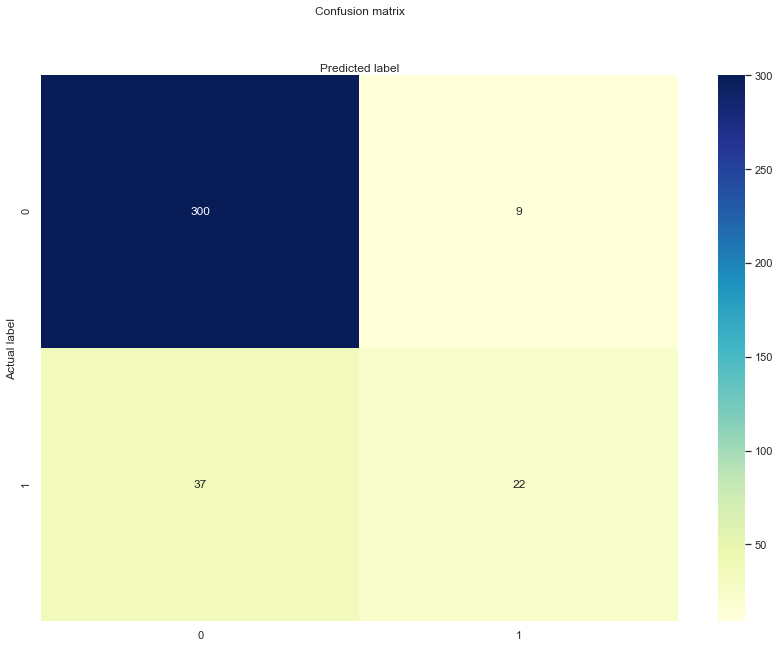

In [46]:
## Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, rf_opt.predict(X_test))
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [47]:
print('Accuracy of RandomForest Regression Classifier on test set: {:.2f}'.format(rf_opt.score(X_test, y_test)*100))

Accuracy of RandomForest Regression Classifier on test set: 87.50


In [48]:
# Classification report for the optimised RF Regression
rf_opt.fit(X_train, y_train)
print(classification_report(y_test, rf_opt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       309
           1       0.71      0.37      0.49        59

    accuracy                           0.88       368
   macro avg       0.80      0.67      0.71       368
weighted avg       0.86      0.88      0.86       368



<a class="anchor" id="m5"></a>
### 5.3.3. Support-Vector Machine

In [49]:
svm_classifier = SVC(random_state=7)

param_grid = {'C': np.arange(0.1, 2, 10)
             }

grid_obj = GridSearchCV(svm_classifier,
                        return_train_score=True,
                        param_grid=param_grid,
                        scoring='roc_auc',
                        cv=10)

grid_fit = grid_obj.fit(X_train, y_train)
svm_opt = grid_fit.best_estimator_

print('='*20)
print("best params: " + str(grid_obj.best_estimator_))
print("best params: " + str(grid_obj.best_params_))
print('best score:', grid_obj.best_score_)
print('='*20)

best params: SVC(C=0.1, random_state=7)
best params: {'C': 0.1}
best score: 0.8048533002105314


Text(0.5, 527.9871999999999, 'Predicted label')

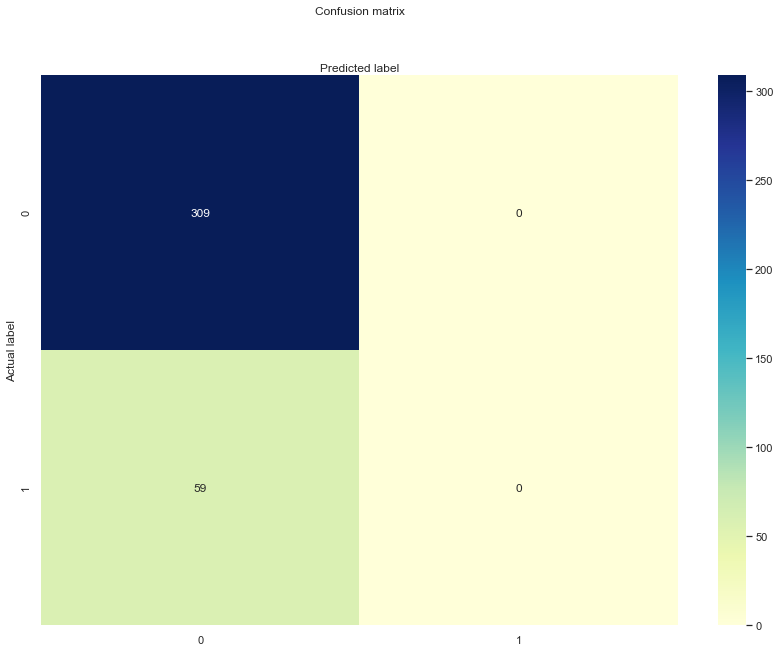

In [50]:
## Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, svm_opt.predict(X_test))
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [51]:
print('Accuracy of SVM Classifier on test set: {:.2f}'.format(svm_opt.score(X_test, y_test)*100))

Accuracy of SVM Classifier on test set: 83.97


Notice that our SVM model just predicted everything as 0. We're going to discard this model.
<a class="anchor" id="m6"></a>
### 5.3.4. XGBoost

In [52]:
from xgboost import XGBClassifier

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

[12:06:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Text(0.5, 527.9871999999999, 'Predicted label')

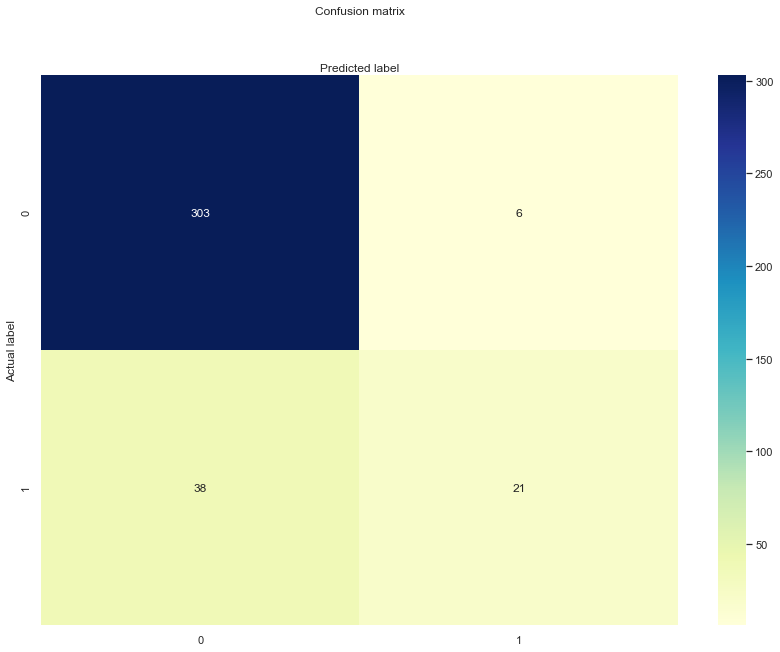

In [53]:
## Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, model.predict(X_test))
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [54]:
print('Accuracy of XGBoost Classifier on test set: {:.2f}'.format(model.score(X_test, y_test)*100))

Accuracy of XGBoost Classifier on test set: 88.04


In [55]:
# Classification report for the XGBoost

print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       309
           1       0.78      0.36      0.49        59

    accuracy                           0.88       368
   macro avg       0.83      0.67      0.71       368
weighted avg       0.87      0.88      0.86       368



<a class="anchor" id="m7"></a>
## 5.4. Voting Ensemble

So, as we evaluated three good models, we can come up with an even better model using Voting Ensemble. 

In [56]:
from sklearn.ensemble import VotingClassifier

vote = VotingClassifier(estimators=[
                            ('lr', log_opt), ('rf', rf_opt), ('XG', model)], voting='hard')
vote.fit(X_train, y_train)

[12:06:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.581,
                                                 class_weight='balanced',
                                                 random_state=8,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=10,
                                                     min_samples_leaf=3,
                                                     min_samples_split=10,
                                                     n_estimators=150,
                                                     random_state=7)),
                             ('XG',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            co

Text(0.5, 527.9871999999999, 'Predicted label')

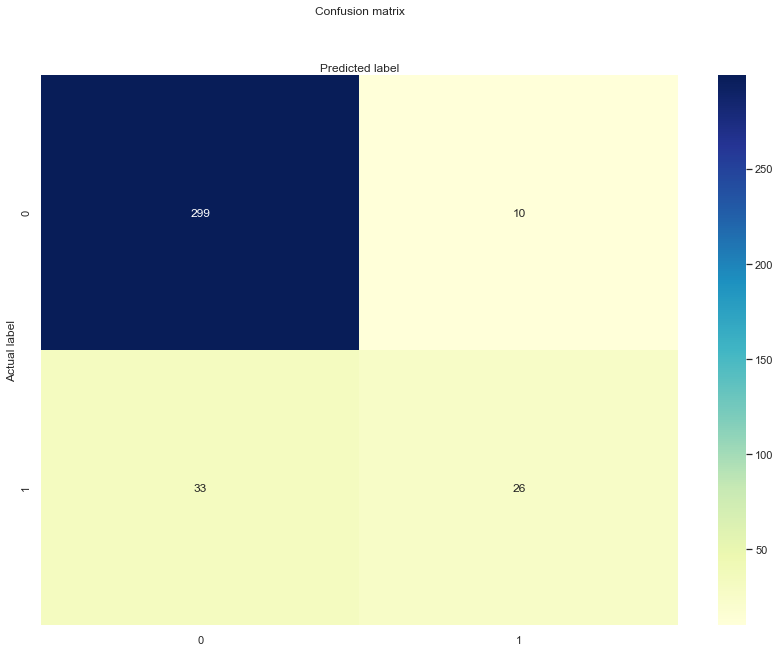

In [57]:
## Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, vote.predict(X_test))
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [58]:
print('Accuracy of Voting Classifier on test set: {:.2f}'.format(vote.score(X_test, y_test)*100))

Accuracy of Voting Classifier on test set: 88.32


In [59]:
# Classification report for the voting ensemble

print(classification_report(y_test, vote.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       309
           1       0.72      0.44      0.55        59

    accuracy                           0.88       368
   macro avg       0.81      0.70      0.74       368
weighted avg       0.87      0.88      0.87       368



<a class="anchor" id="m8"></a>
# 6. Conclusions

Let's recall out feature importance plot:

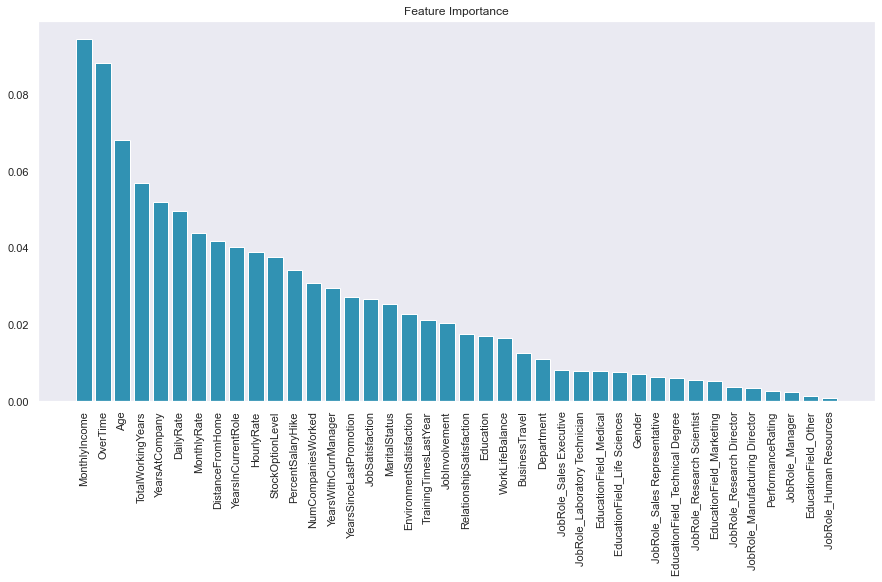

In [60]:
plt.figure(figsize=(15, 7)) # Create plot
plt.title("Feature Importance") # Create plot title
plt.bar(range(X_train.shape[1]), importances[indices],color = '#3192b3') # Add bars
plt.xticks(range(X_train.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.grid(False)
plt.show() # Show plot

The stronger indicators of people leaving include:

- __Monthly Income__: people on higher wages are less likely to leave the company. Hence, efforts should be made to gather information on industry benchmarks in the current local market to determine if the company is providing competitive wages.
<br>

- __Over Time__: people who work overtime are more likelty to leave the company. Hence efforts must be taken to appropriately scope projects upfront with adequate support and manpower so as to reduce the use of overtime.
<br>

- __Age__: Employees in relatively young age bracket 25-35 are more likely to leave. Hence, efforts should be made to clearly articulate the long-term vision of the company and young employees fit in that vision, as well as provide incentives in the form of clear paths to promotion for instance.
<br>

- __TotalWorkingYears__: The more experienced employees are less likely to leave. Employees who have between 5-8 years of experience should be identified as potentially having a higher-risk of leaving.
<br>

- __YearsAtCompany__: Loyal companies are less likely to leave. Employees who hit their two-year anniversary should be identified as potentially having a higher-risk of leaving.
<br>

- __DistanceFromHome__: Employees who live further from home are more likely to leave the company. Hence, efforts should be made to provide support in the form of company transportation for clusters of employees leaving the same area, or in the form of Transportation Allowance. Initial screening of employees based on their home location is probably not recommended as it would be regarded as a form of discrimination as long as employees make it to work on time every day.
<br>
